# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно определятить рыночную стоимость объектов недвижимости. Для этого проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Импорты, data frames, общая информация

In [219]:
from typing import Final

import pandas as pd
import missingno as msno

In [335]:
# Константы для размеров гистограмм
HIST_SIZE: Final = (15, 8)
BIG_HIST_SIZE: Final = (15, 20)
BOX_SIZE: Final = (8, 12)

In [221]:
try:
    data = pd.read_csv("I'm sorry but dni", sep='\t')
except:
    data = pd.read_csv("I'm sorry but dni", sep='\t')

In [222]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [223]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


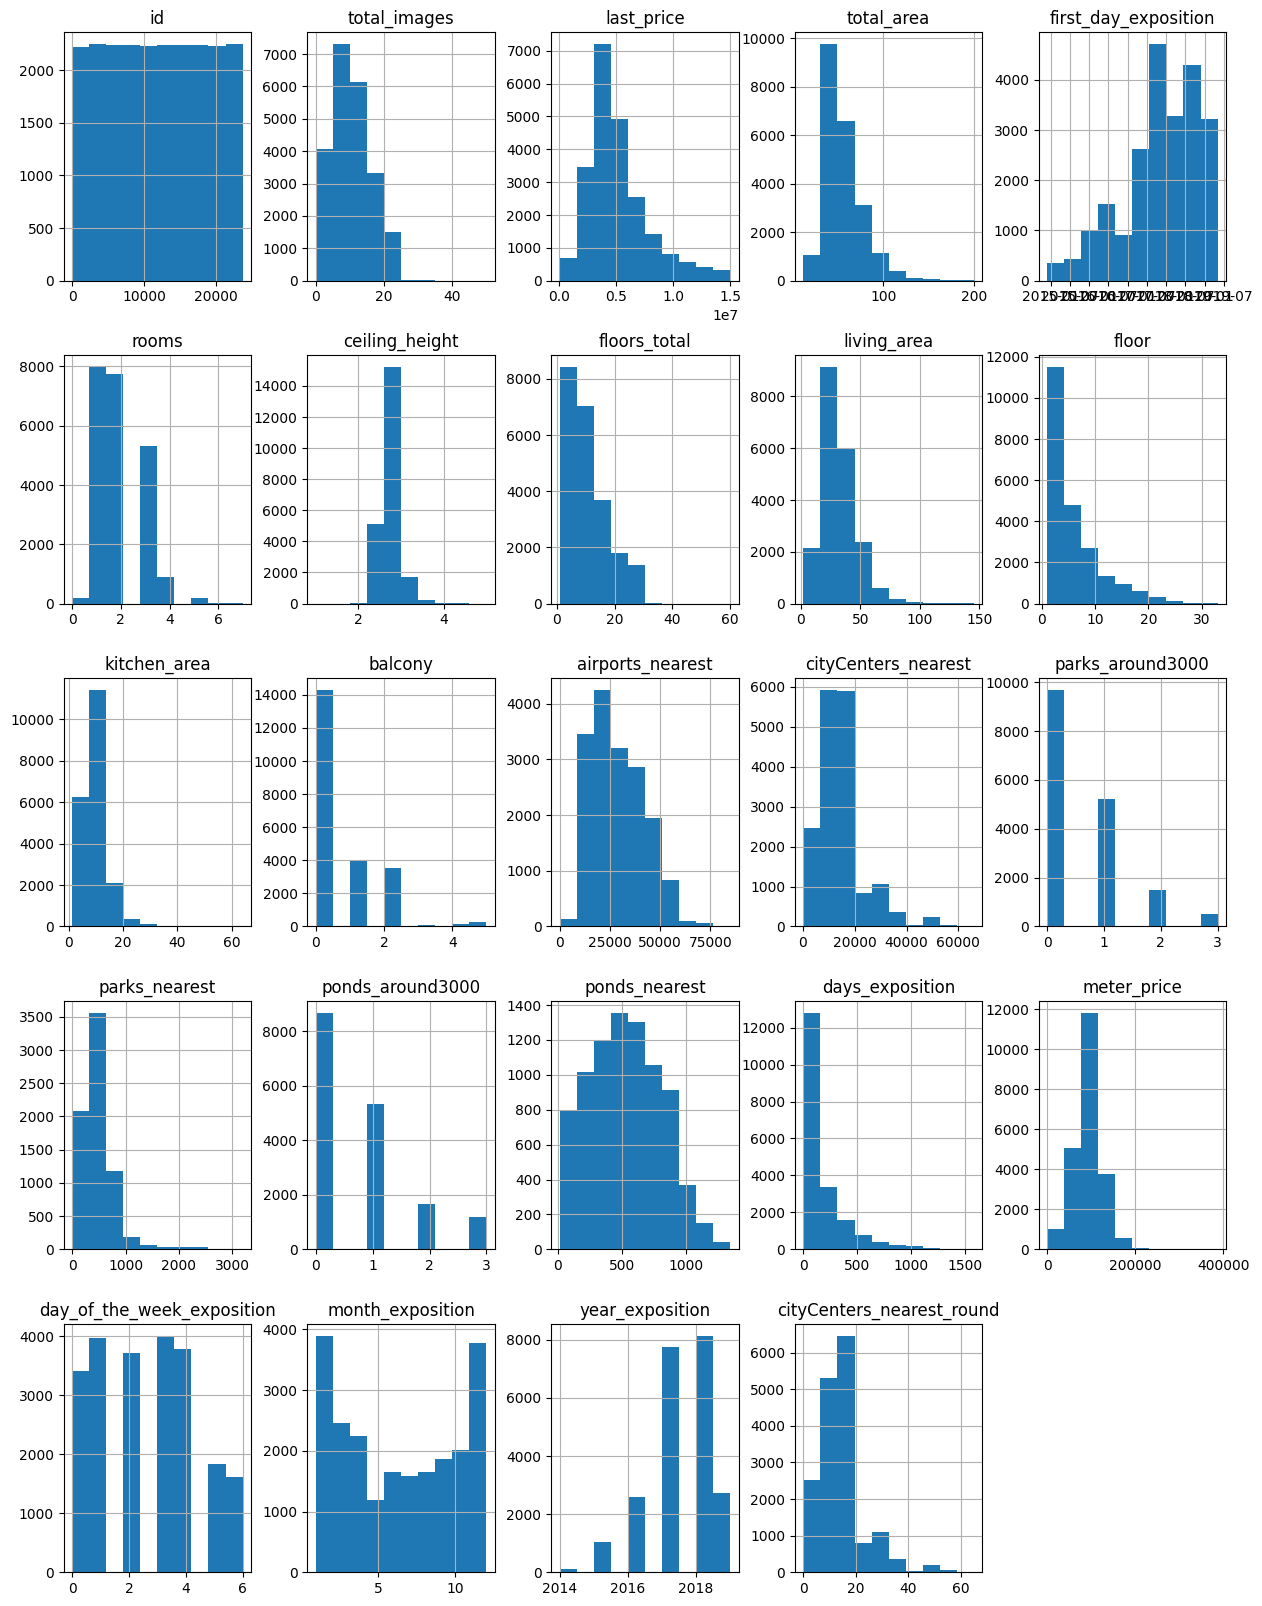

In [336]:
data.hist(figsize=BIG_HIST_SIZE)
plt.show()

#### Промежуточный вывод:
1. Датасет содержит 23,699 записей и 22 столбца.
2. Некоторые столбцы, такие как ceiling_height, balcony, airports_nearest, parks_nearest, имеют значительное количество пропущенных значений, которые требуют обработки.
3. Набор данных содержит различные объявления недвижимости с широким диапазоном цен и размеров, что может отражать разные сегменты рынка.
4. Смещенные распределения в нескольких столбцах (`last_price`, `total_area`, `ceiling_heigth` и т.д.) указывают на наличие выбросов, влияющих на средние значения.

### Предобработка данных

#### Пропуски в данных:

In [225]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

##### Матрица пропущенных значений

<Axes: >

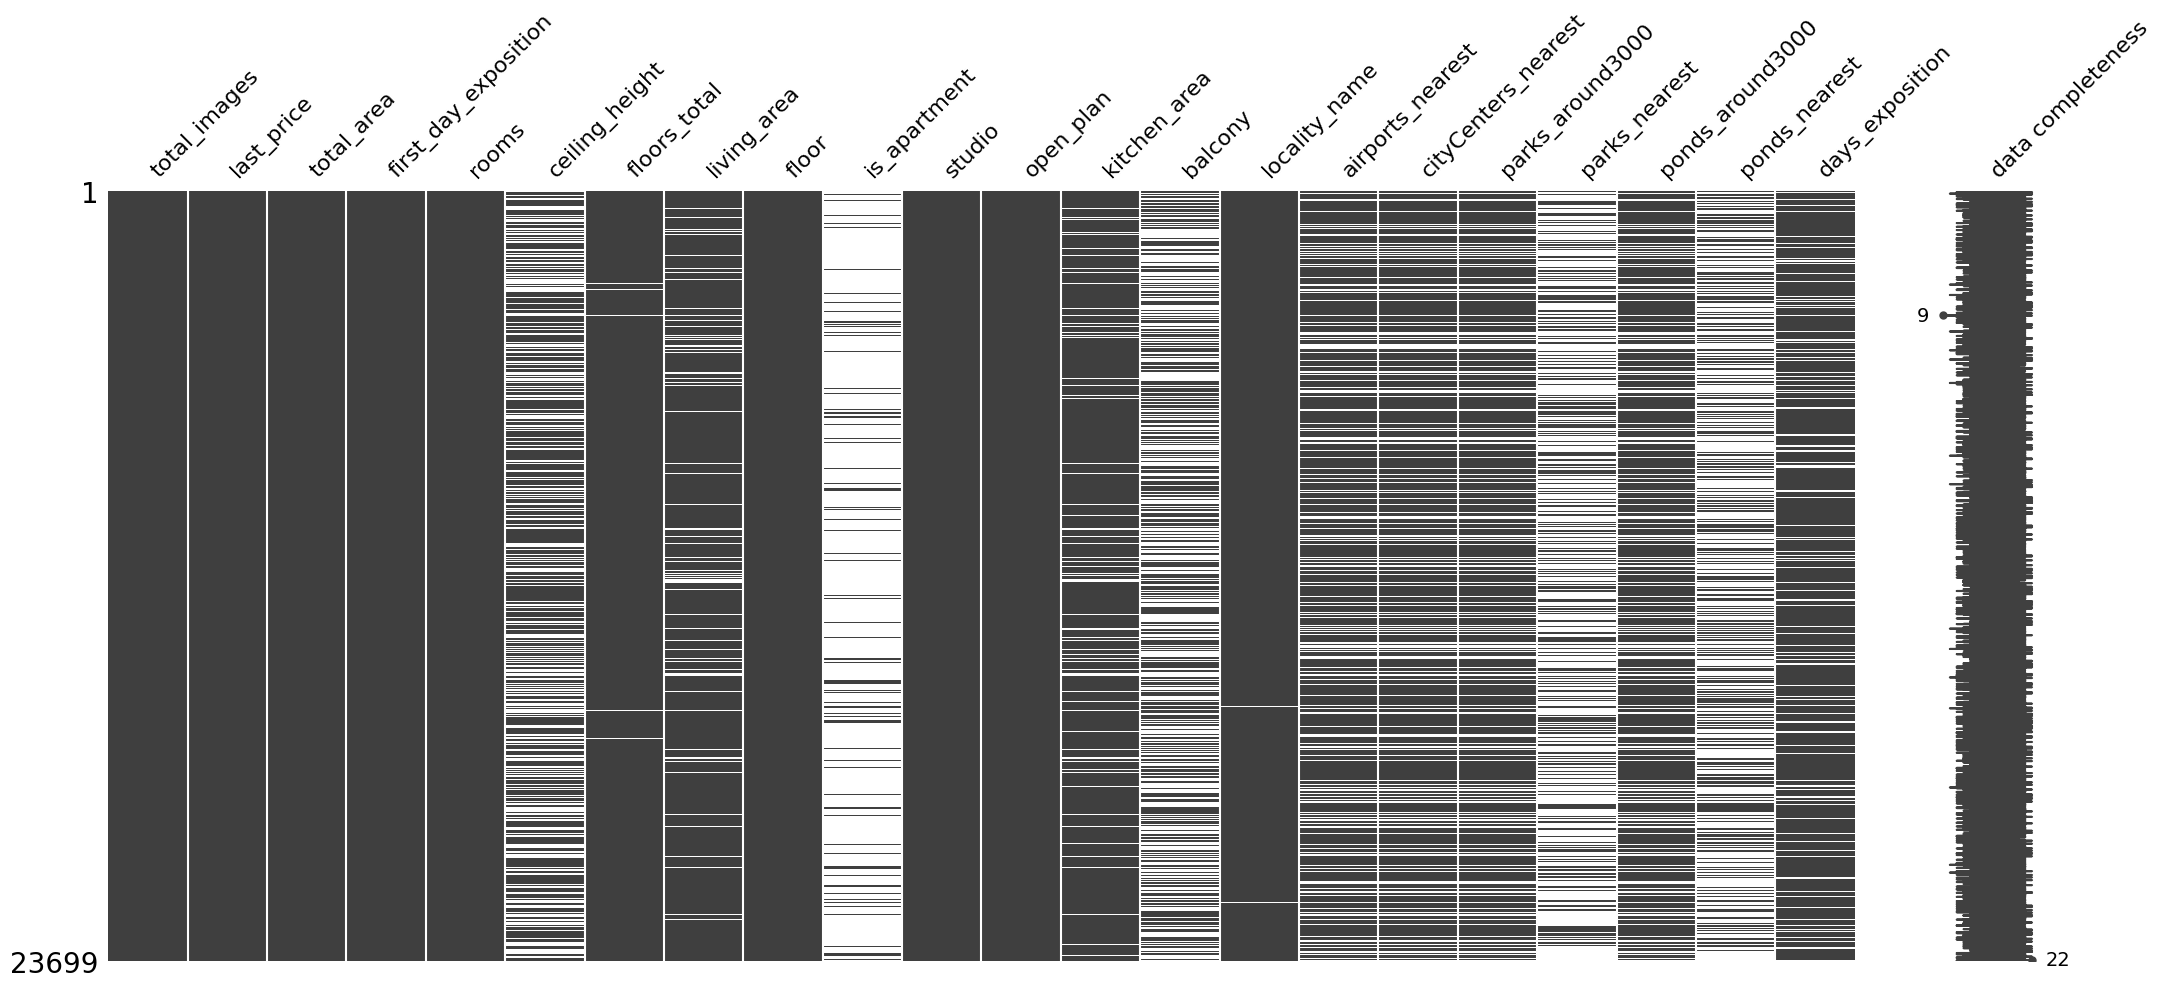

In [226]:
msno.matrix(data, labels=True)

##### Гистограмма: Соотношение пропущенных значений

<Axes: >

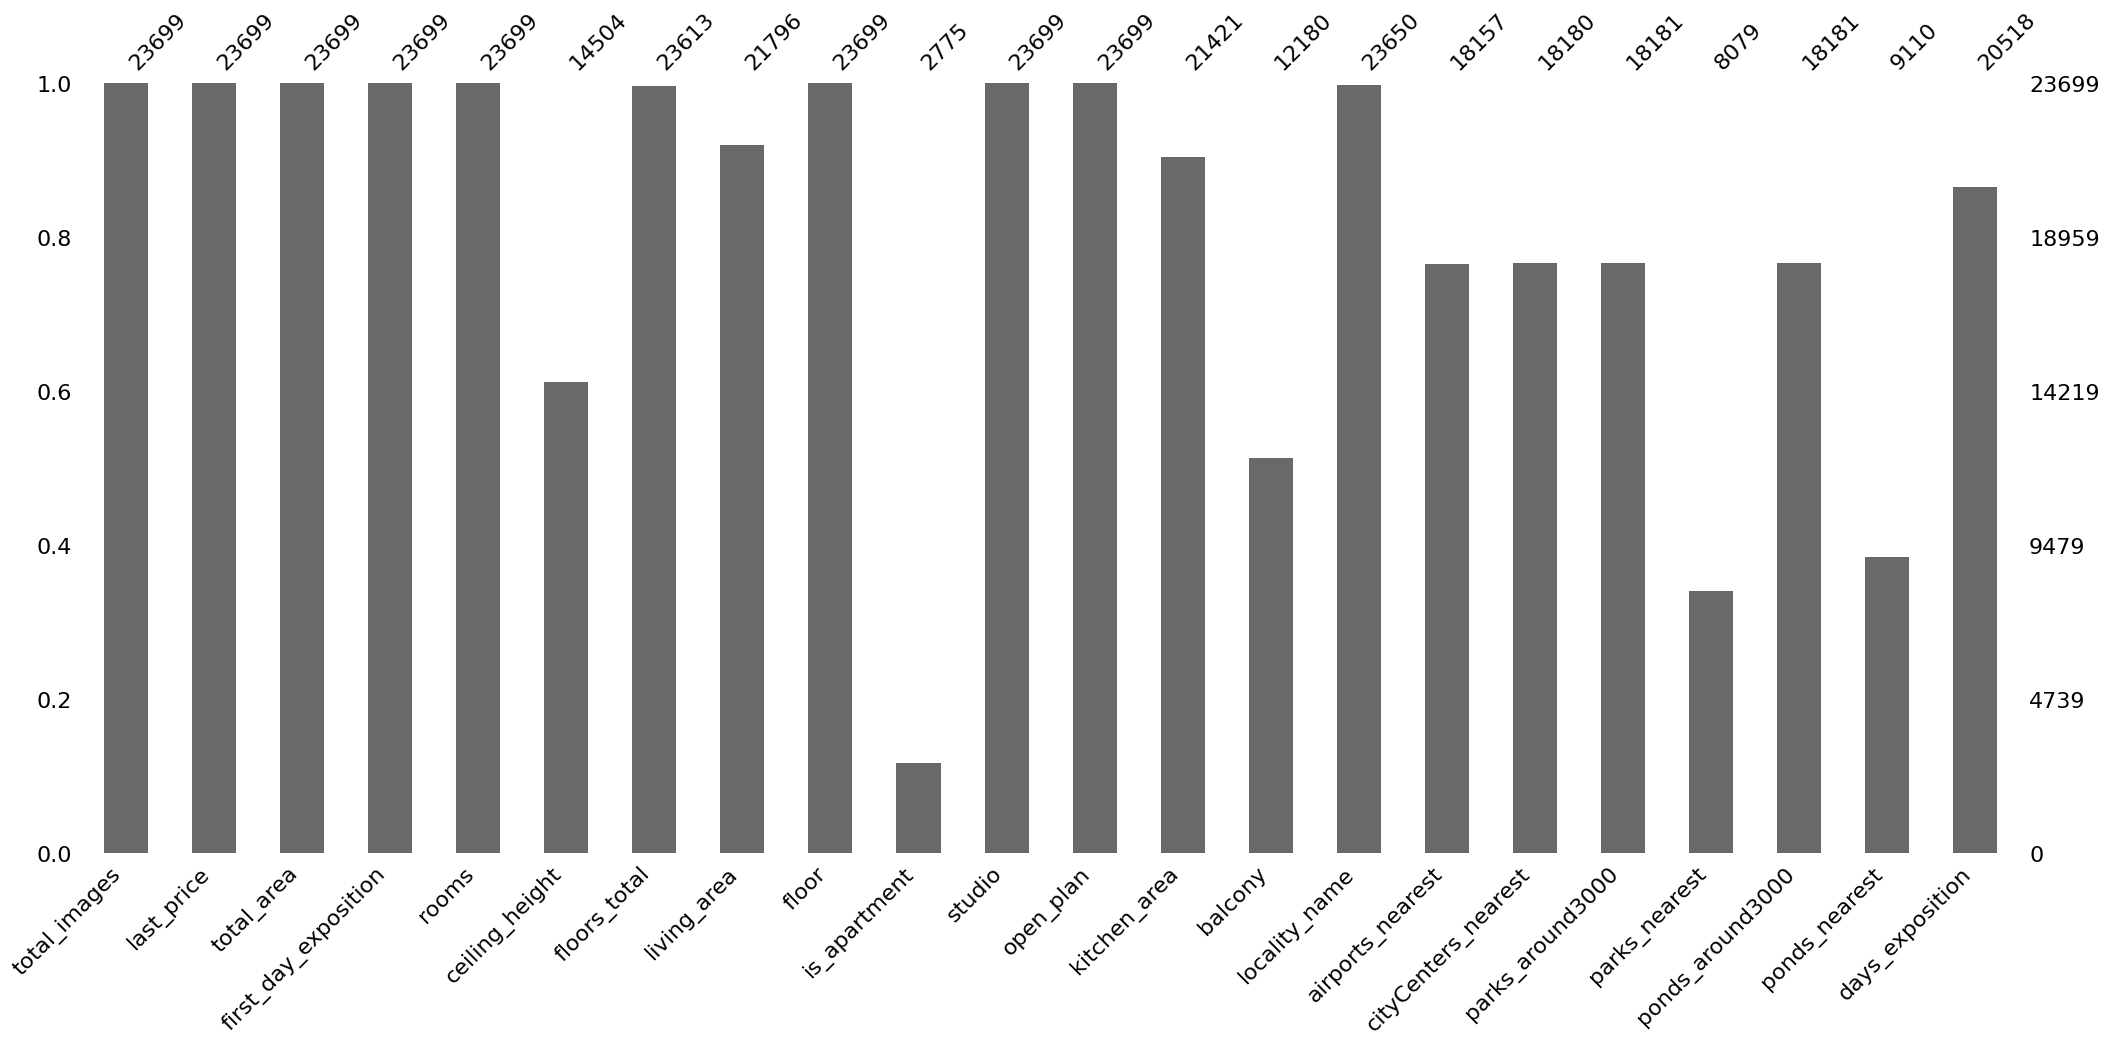

In [227]:
msno.bar(data)

##### Пропуски присутствуют в столбцах:
 - `ceiling_height`
 - `floors_total`
 - `living_area`
 - `is_apartment`
 - `kitchen_area`
 - `balcony`
 - `locality_name`
 - `airports_nearest`
 - `cityCenters_nearest`
 - `parks_around3000`
 - `parks_nearest`
 - `ponds_around3000`
 - `ponds_nearest`
 - `days_exposition`

In [228]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

##### Выводы:

> По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

Обобщённо можно предположить, что пропуски в данных возникли по двум основным причинам:

1. Человеческий фактор:
   - `ceiling_height`: Логичная замена — медианное значение, так как высота потолков регламентируется СНИП и СанПин.
   - `floors_total`: Логичную замену предположить нельзя. Без точного адреса восстановить этажность невозможно, и эти данные могут искажать результаты.
   - `living_area`: Логичную замену предположить нельзя.
   - `kitchen_area`: Логичную замену предположить нельзя. Согласно СНИП, кухня должна быть во всех жилых помещениях.
   - `balcony`: Логично предположить, что балконов нет (замена на 0).
   - `locality_name`: Логичную замену предположить нельзя. Эти данные могут искажать результаты.
2. Техническая ошибка:
   - `airports_nearest`: Заполняется автоматически.
   - `cityCenters_nearest`: Заполняется автоматически.
   - `parks_around3000`: Заполняется автоматически.
   - `parks_nearest`: Заполняется автоматически.
   - `ponds_around3000`: Заполняется автоматически.
   - `ponds_nearest`: Заполняется автоматически.
   - `is_apartment`: Вероятно, столбец типа bool. Логичная замена — False.
   - `days_exposition`: Заполняется автоматически. Логичную замену предположить нельзя, так как отсутствие значения может говорить сразу о нескольких вариантах (не было опубликовано, снято с публикации по иным причинам и т.д., продажа не состоялась).

Для столбцов, заполняемых автоматически, логичную замену предположить нельзя, так как нам неизвестен алгоритм их заполнения. Лучшее, что мы можем сделать обратиться к разработчикам системы или составить bug report, чтобы выяснить причины пропусков и способы их устранения.

In [229]:
# удалим строки где неуказана локация или этажность
data.dropna(subset=['floors_total', 'locality_name'], inplace=True)

In [230]:
# ceiling_height
data['ceiling_height'] = data['ceiling_height'].where(~data['ceiling_height'].isna(), data['ceiling_height'].median(axis=0))

In [231]:
# balcony
data['balcony'] = data['balcony'].fillna(value=0)


In [232]:
# is_apartment
data['is_apartment'] = data['is_apartment'].fillna(value=False)

C:\Users\Max\AppData\Local\Temp\ipykernel_2672\3350174619.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_apartment'] = data['is_apartment'].fillna(value=False)


In [233]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest      18


##### Преобразование типов данных:

- `last_price`: Преобразовать в int, так как знаки после запятой не изменят результаты анализа.
- `first_day_exposition`: Преобразовать в datetime, что логично для работы с датами.
- `floors_total`: Преобразовать в int, по естественным причинам.
- `balcony`: Преобразовать в int, по естественным причинам.

##### Округление площадей:

- `total_area`, `living_area`, `kitchen_area`: Округлить значения для удобства восприятия. Это не должно исказить общую картину.

##### Преобразование автоматически заполняемых столбцов в int:

- `airports_nearest`
- `cityCenters_nearest`
- `parks_around3000`
- `parks_nearest`
- `ponds_around3000`
- `ponds_nearest`
- `days_exposition`

Знаки после запятой не несут значительной смысловой нагрузки, и количество дней является целочисленным.

In [234]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

#### Уникальные значения в столбце с названиями и устранение неявных дубликатов

In [235]:
len_unique_locality_name_before = len(data['locality_name'].unique())
print(f'Уникальных названий населённых пунктов, до обработки: {len_unique_locality_name_before}')

Уникальных названий населённых пунктов, до обработки: 364


In [236]:
# добавим короткое название населённого пункта

def short_locality_name(item):
    short_locality_name = []
    for word in item.split(' '):
        if word[0].istitle():
            short_locality_name.append(word)
    return str.join(' ', short_locality_name)

data['short_locality_name'] = data['locality_name'].apply(short_locality_name)

In [237]:
# получим список 'имен собственных' которые встречаются в уникальных 'локальных именах' более одного раза
dubl_list = pd.pivot_table(data, index=['short_locality_name'], values=['locality_name'], aggfunc=lambda x: len(x.unique())).query('locality_name > 1').index

##### Использование КЛАДР
Проверка данных по официальным источникам, таким как КЛАДР и Википедия, позволяет избежать ошибок и неточностей при анализе и классификации населенных пунктов.

In [238]:
# подключим КЛАДР, будет лучше если мы будем знать сколько населённых пунктов в области действительно называются одинаково
try:
    kladr = pd.read_csv('kladr.csv')
except:
    kladr = pd.read_csv('https://raw.githubusercontent.com/maxstolpovskikh/kladr_as_csv/main/kladr.csv')

region_list = ['Ленинградская область', 'Санкт-Петербург']
region_kladr = kladr.query('region_name.isin(@region_list).values')

In [239]:
def print_dubl():
    for name in dubl_list:
        res = data[data['short_locality_name'] == name]['locality_name'].unique()
        if len(res) > 1:
            print(res, name, len(region_kladr.query('name == @name')))

print_dubl()

['посёлок Аннино' 'поселок Аннино'] Аннино 1
['городской поселок Большая Ижора' 'поселок городского типа Большая Ижора'] Большая Ижора 1
['посёлок Бугры' 'поселок Бугры'] Бугры 2
['поселок станции Вещево' 'посёлок при железнодорожной станции Вещево'] Вещево 1
['посёлок Возрождение' 'поселок Возрождение'] Возрождение 2
['посёлок городского типа Вырица' 'поселок городского типа Вырица'] Вырица 2
['посёлок Гаврилово' 'поселок Гаврилово'] Гаврилово 1
['деревня Гарболово' 'поселок Гарболово'] Гарболово 2
['посёлок станции Громово' 'поселок Громово'] Громово 2
['поселок Жилгородок' 'посёлок Жилгородок'] Жилгородок 2
['поселок Зимитицы' 'деревня Зимитицы'] Зимитицы 2
['поселок Ильичёво' 'посёлок Ильичёво'] Ильичёво 0
['деревня Калитино' 'поселок Калитино'] Калитино 2
['посёлок Кобралово' 'поселок Кобралово'] Кобралово 3
['посёлок Коробицыно' 'поселок Коробицыно'] Коробицыно 1
['поселок городского типа Красный Бор'
 'посёлок городского типа Красный Бор'] Красный Бор 5
['деревня Кудрово' 'Кудро

##### Неявные дубликаты part 1
Острая необходимость использования "единого написания", достаточно распространённая проблема.

Преобразование всех названий населенных пунктов, заменив 'ё' на 'е', позволяет избежать дубликатов, однако стоит относиться с осторожностью, в системах типа КЛАДР, Фёдоровское не торжественно Федоровское.

In [240]:
# Заменим Ё на Е и посмотрим ещё раз
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
print_dubl()

['городской поселок Большая Ижора' 'поселок городского типа Большая Ижора'] Большая Ижора 1
['поселок станции Вещево' 'поселок при железнодорожной станции Вещево'] Вещево 1
['деревня Гарболово' 'поселок Гарболово'] Гарболово 2
['поселок станции Громово' 'поселок Громово'] Громово 2
['поселок Зимитицы' 'деревня Зимитицы'] Зимитицы 2
['деревня Калитино' 'поселок Калитино'] Калитино 2
['деревня Кудрово' 'Кудрово'] Кудрово 1
['поселок Лесное' 'коттеджный поселок Лесное'] Лесное 2
['городской поселок Лесогорский' 'поселок городского типа Лесогорский'] Лесогорский 1
['Любань' 'поселок Любань'] Любань 2
['городской поселок Мга' 'поселок городского типа Мга'] Мга 1
['поселок Мурино' 'Мурино'] Мурино 1
['городской поселок Назия' 'поселок городского типа Назия'] Назия 3
['Никольское' 'село Никольское'] Никольское 7
['село Павлово' 'городской поселок Павлово'
 'поселок городского типа Павлово'] Павлово 3
['поселок станции Приветнинское'
 'поселок при железнодорожной станции Приветнинское'] Привет

##### Неявные дубликаты part 2
Можно сделать следующие предположения:
 - **городской поселок** и **поселок городского типа** - вероятно относятся к одному и тому же типу населенного пункта.
 - **поселок станции** и **поселок при железнодорожной станции** - аналогично, вероятно могут относиться к населенным пунктам, расположенным при железнодорожных станциях.

Необходимо учитывать различия при анализе следующих пар населенных пунктов:

1. 'поселок Лесное' и 'коттеджный поселок Лесное'
2. Название "Калитино" может использоваться как для деревни, так и для поселка, но это могут быть разные населенные пункты с одинаковым названием.
3. 'поселок Зимитицы' и 'деревня Зимитицы', Название "Зимитицы" может использоваться как для поселка, так и для деревни, но это не обязательно одно и то же место.

In [241]:
# Продолжим и сократим список
data['locality_name'] = data['locality_name'].str.replace('поселок станции', 'поселок при железнодорожной станции')

In [242]:
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок городского типа')

In [243]:
print_dubl()

['деревня Гарболово' 'поселок Гарболово'] Гарболово 2
['поселок при железнодорожной станции Громово' 'поселок Громово'] Громово 2
['поселок Зимитицы' 'деревня Зимитицы'] Зимитицы 2
['деревня Калитино' 'поселок Калитино'] Калитино 2
['деревня Кудрово' 'Кудрово'] Кудрово 1
['поселок Лесное' 'коттеджный поселок Лесное'] Лесное 2
['Любань' 'поселок Любань'] Любань 2
['поселок Мурино' 'Мурино'] Мурино 1
['Никольское' 'село Никольское'] Никольское 7
['село Павлово' 'поселок городского типа Павлово'] Павлово 3
['поселок городского типа Приладожский'
 'садовое товарищество Приладожский'] Приладожский 1
['деревня Рабитицы' 'поселок Рабитицы'] Рабитицы 2
['поселок городского типа Рахья' 'садовое товарищество Рахья'] Рахья 2
['поселок Рябово' 'поселок городского типа Рябово'] Рябово 2
['деревня Федоровское' 'поселок городского типа Федоровское'] Фёдоровское 1
['поселок Щеглово' 'деревня Щеглово'] Щеглово 3


##### Неявные дубликаты part 3
- ['поселок Мурино' 'Мурино'] Мурино 1
- ['деревня Кудрово' 'Кудрово'] Кудрово 1
- ['деревня Федоровское' 'поселок городского типа Федоровское'] Фёдоровское 1

На основании информации из КЛАДР и Википедии, можно уточнить следующее:
Учитывая, что Мурино и Кудрово являются городами, а Фёдоровское - городским поселком, можно объединить различные обозначения этих населенных пунктов для более точного анализа данных.


In [244]:
data['locality_name'] = data['locality_name'].str.replace('деревня Федоровское', 'поселок городского типа Федоровское')
data['locality_name'] = data['locality_name'].str.replace('поселок Мурино', 'Мурино')
data['locality_name'] = data['locality_name'].str.replace('деревня Кудрово', 'Кудрово')

In [245]:
print_dubl()

['деревня Гарболово' 'поселок Гарболово'] Гарболово 2
['поселок при железнодорожной станции Громово' 'поселок Громово'] Громово 2
['поселок Зимитицы' 'деревня Зимитицы'] Зимитицы 2
['деревня Калитино' 'поселок Калитино'] Калитино 2
['поселок Лесное' 'коттеджный поселок Лесное'] Лесное 2
['Любань' 'поселок Любань'] Любань 2
['Никольское' 'село Никольское'] Никольское 7
['село Павлово' 'поселок городского типа Павлово'] Павлово 3
['поселок городского типа Приладожский'
 'садовое товарищество Приладожский'] Приладожский 1
['деревня Рабитицы' 'поселок Рабитицы'] Рабитицы 2
['поселок городского типа Рахья' 'садовое товарищество Рахья'] Рахья 2
['поселок Рябово' 'поселок городского типа Рябово'] Рябово 2
['поселок Щеглово' 'деревня Щеглово'] Щеглово 3


In [246]:
len_unique_locality_name_after = len(data['locality_name'].unique())
print(f'Уникальных названий населённых пунктов, после обработки: {len_unique_locality_name_after}, разница: {len_unique_locality_name_before - len_unique_locality_name_after}')

Уникальных названий населённых пунктов, после обработки: 318, разница: 46


##### Выводы:
Необходимость контекста и дополнительных данных.
Для точного определения, являются ли указанные населенные пункты одним и тем же местом, необходимо использовать дополнительные данные и контекст. Без этого нельзя утверждать, что они идентичны.
##### Рекомендация:
Рассмотреть варианты внедрения КЛАДР или других, подобных систем (например Росреестр как у конкурентов) для реализации "единого" и "верного" именования населённых пунктов пользователем при размещении объявления.

### Добавление новых столбцов

 - Цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой)
 - День недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
 - месяц публикации объявления
 - год публикации объявления
 - тип этажа квартиры (значения — «первый», «последний», «другой»)
 - расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений)

In [247]:
def floor_type(row):
    if row['floor'] == 1:
        return('первый')
    if row['floor'] == row['floors_total']:
        return('последний')
    return('другой')

data['meter_price'] = data['last_price'] / data['total_area']
data['day_of_the_week_exposition'] = data['first_day_exposition'].dt.dayofweek
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year
data['floor_type'] = data.apply(floor_type, axis=1)
data['cityCenters_nearest_round'] = data[~data['cityCenters_nearest'].isna()]['cityCenters_nearest'].apply(lambda x: int(x / 1000))

### EDA (Исследовательский анализ)

#### Параметры
* общая площадь;
* жилая площадь;
* площадь кухни;
* цена объекта;
* количество комнат;
* высота потолков;
* тип этажа квартиры («первый», «последний», «другой»);
* общее количество этажей в доме;
* расстояние до центра города в метрах;
* расстояние до ближайшего парка

##### Общая площадь

In [248]:
data['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

<Axes: >

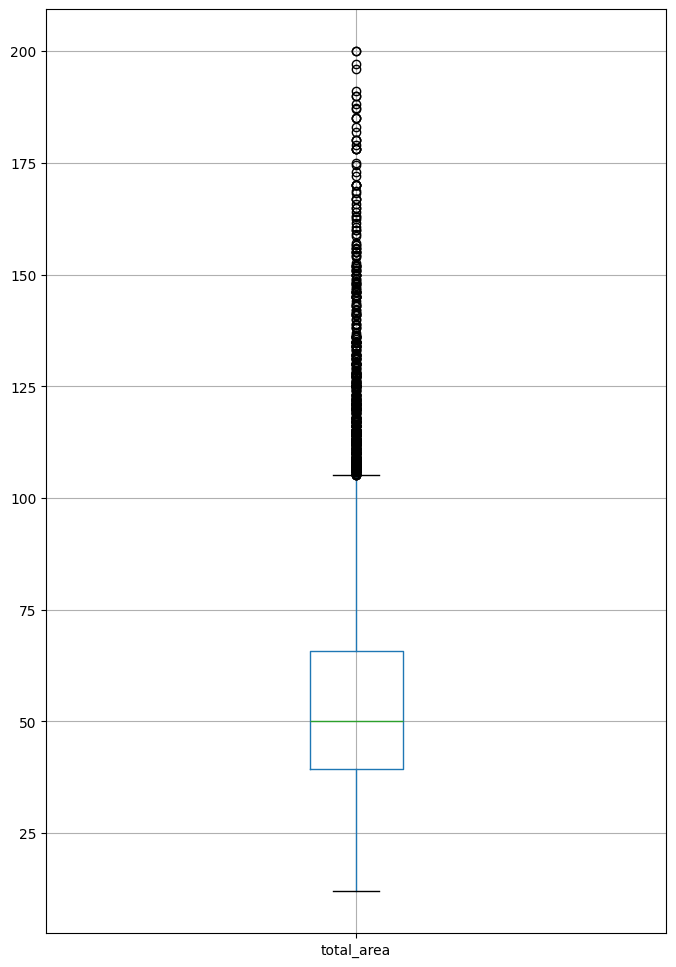

In [295]:
data.boxplot(column='total_area', figsize=BOX_SIZE)

Нельзя утверждать, что площадь более 200 кв.м. является искаженными данными, так как рынок недвижимости очень разнообразен. Однако таких данных немного, поэтому целесообразно их удалить.

In [250]:
data.drop(index=data[data['total_area'] > 200].index, inplace=True)

<Axes: >

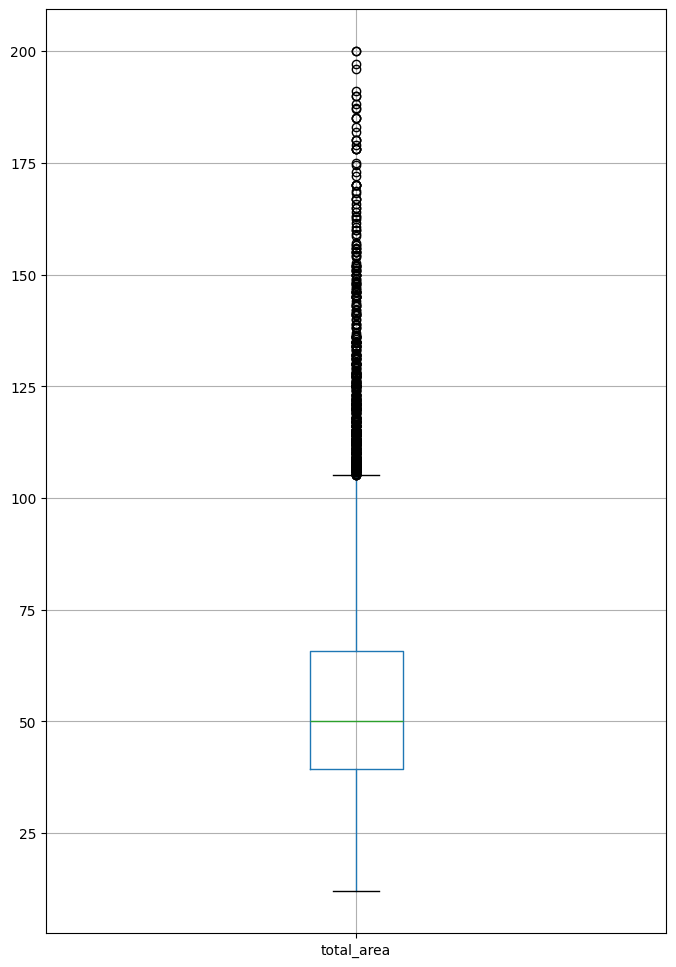

In [297]:
data.boxplot(column='total_area', figsize=BOX_SIZE)

###### Гистограмма: Общая площадь

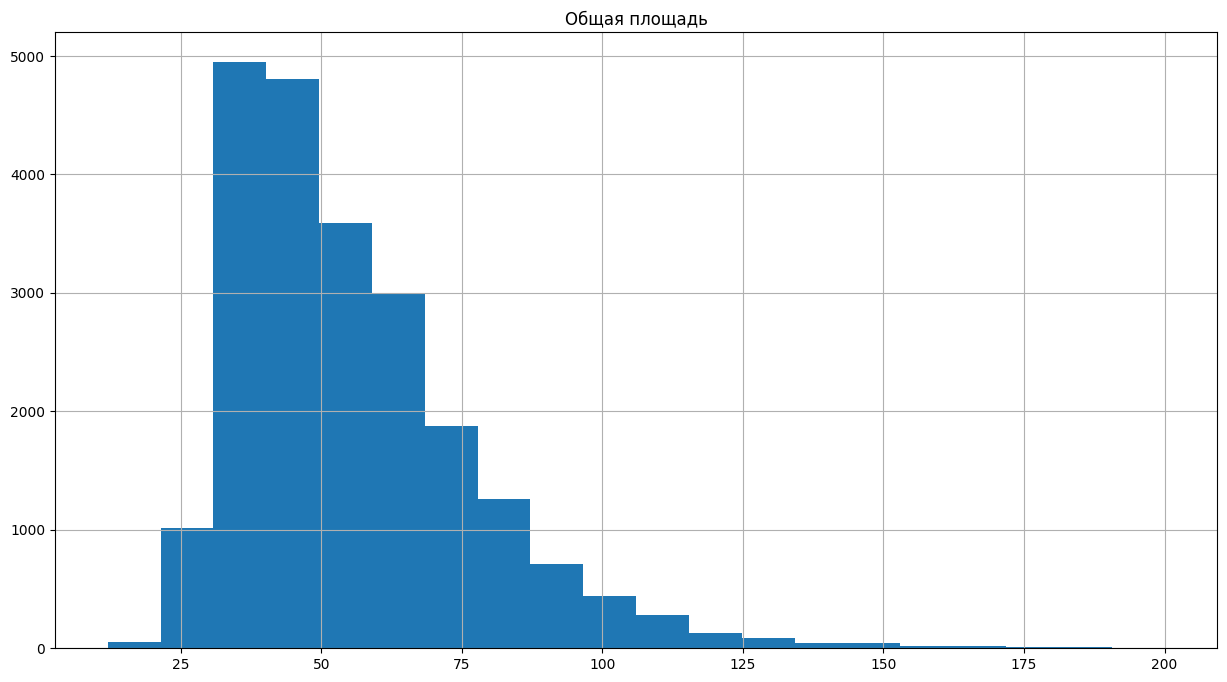

In [299]:
data.hist('total_area', bins=20, figsize=HIST_SIZE)
plt.title('Общая площадь')
plt.show()

###### Выводы:
1. Гистограмма имеет правый (положительный) скос, что характерно для распределения Пуассона.
2. Значения площади варьируются от 0 до 200 квадратных метров.
3. Основная масса объектов недвижимости имеет площадь в диапазоне от 30 до 50 квадратных метров.
4. Пик распределения находится около 50 квадратных метров.
5. Крупные объекты недвижимости (более 100 квадратных метров) встречаются редко и составляют небольшую часть общего жилищного фонда.




##### Жилая площадь

In [253]:
data['living_area'].describe()

count    21502.000000
mean        33.248079
std         17.368396
min          2.000000
25%         18.600000
50%         30.000000
75%         42.000000
max        164.700000
Name: living_area, dtype: float64

<Axes: >

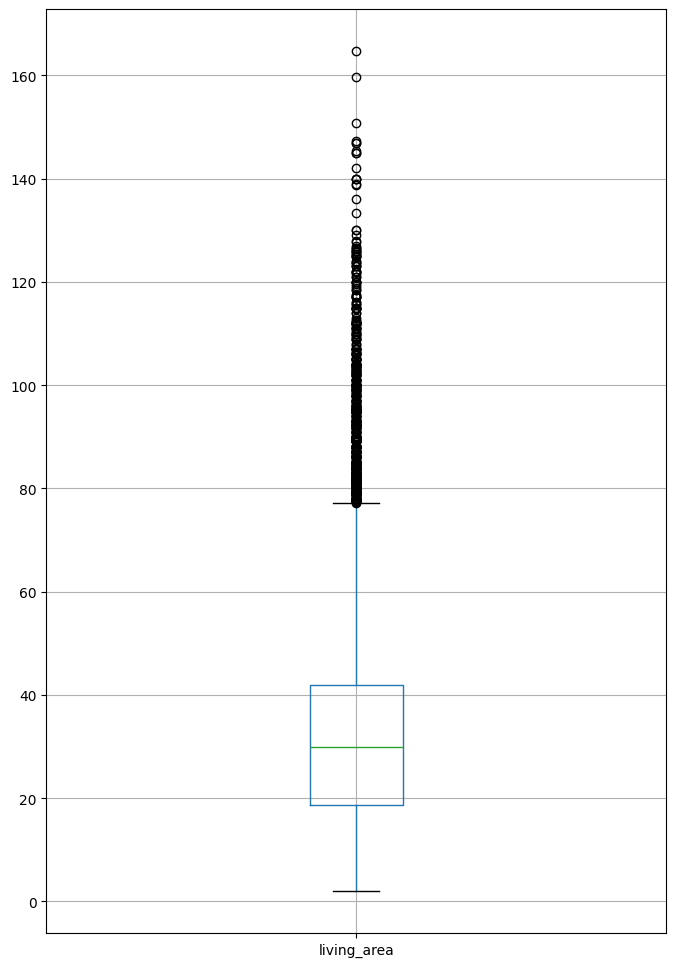

In [254]:
data.boxplot(column='living_area', figsize=BOX_SIZE)

###### Гистограмма: Жилая площадь

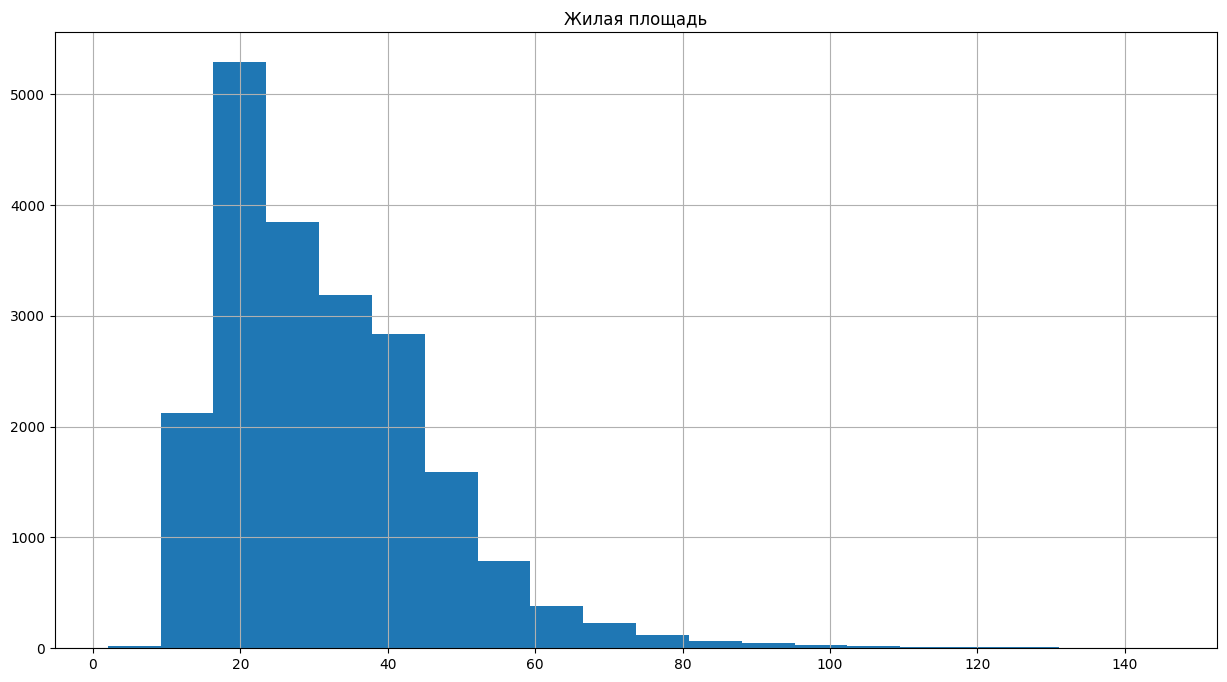

In [300]:
data.hist('living_area', figsize=HIST_SIZE, bins=20)
plt.title('Жилая площадь')
plt.show()

###### Выводы:
1. Большая часть данных сосредоточена в диапазоне до 40 квадратных метров.
2. Пик распределения находится около 20 квадратных метров.
3. Небольшое количество объектов имеет жилую площадь больше 60 квадратных метров.
4. Очень мало объектов с жилой площадью более 80 квадратных метров.

##### Площадь кухни

In [256]:
data['kitchen_area'].describe()

count    21146.000000
mean        10.377349
std          5.364057
min          1.300000
25%          7.000000
50%          9.000000
75%         11.950000
max         93.200000
Name: kitchen_area, dtype: float64

###### Гистограмма: Площадь кухни

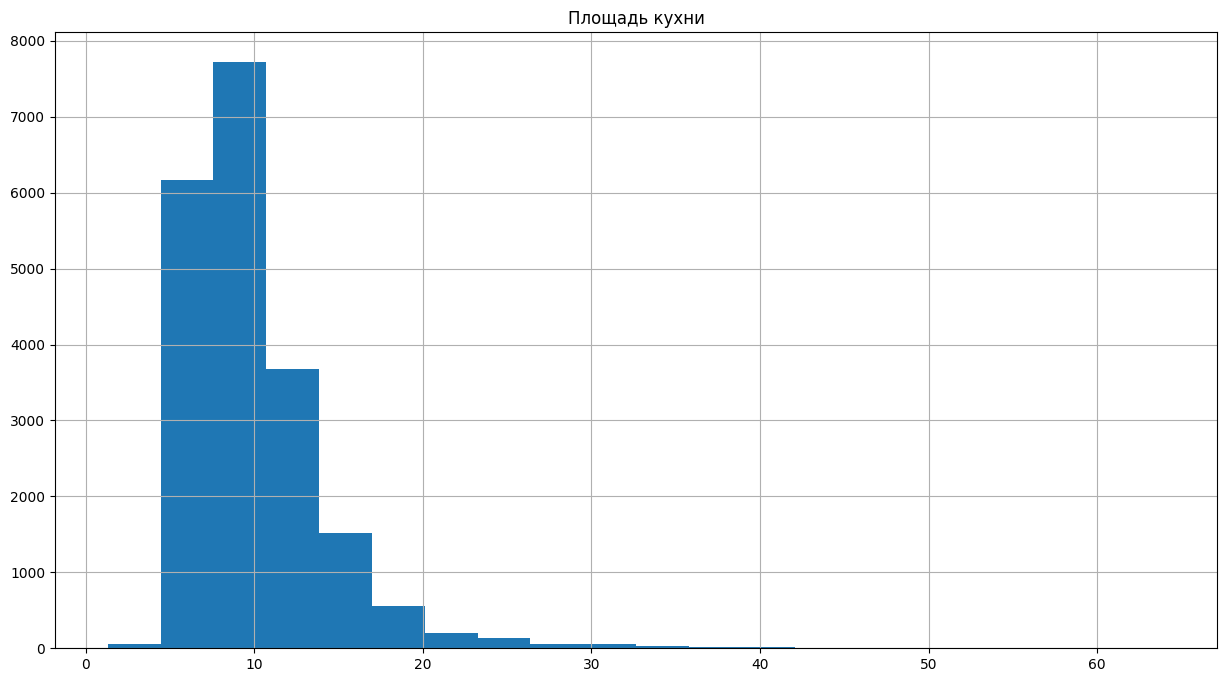

In [301]:
data.hist('kitchen_area', figsize=HIST_SIZE, bins=20)
plt.title('Площадь кухни')
plt.show()

###### Выводы:
1. Распределение имеет выраженный правый скос, что указывает на наличие небольшого числа кухонь с очень большой площадью.
2. Большинство значений площади кухни сконцентрированы в диапазоне от 5 до 15 квадратных метров.
3. Наибольшее количество кухонь имеет площадь около 10 квадратных метров.
4. Площадь кухни более 20 квадратных метров встречается крайне редко.
5. Значения выше 40 квадратных метров практически отсутствуют и могут быть аномальными или специфическими.

##### Цена объекта

<Axes: >

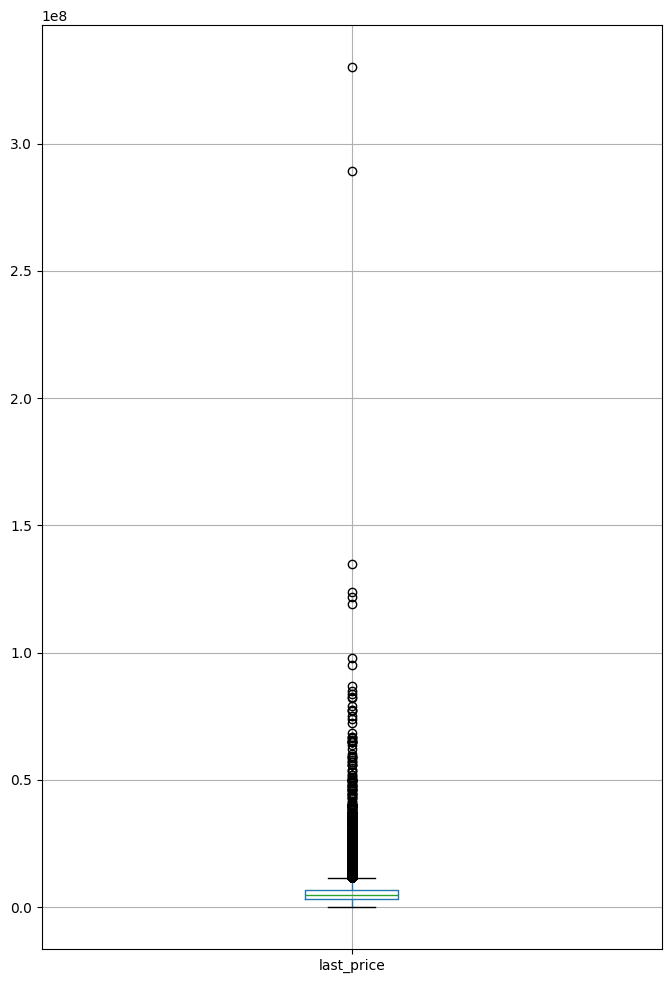

In [258]:
data.boxplot(column='last_price', figsize=BOX_SIZE)

In [259]:
anomalies = data[data['last_price'] > 15000000]['last_price'].index

print(len(anomalies))

980


###### Аномалии
1. На диаграмме видны выбросы (аномалии).
2. Аномалии включают цены, которые значительно превышают 15,000,000 рублей.
3. Было выявлено 988 аномальных значений.
4. Удаление аномалий из данных о ценах на объекты недвижимости позволит получить более точные и репрезентативные статистические показатели и сосредоточиться на анализе основных тенденций рынка.

In [260]:
data.drop(index=anomalies, inplace=True)

###### Гистограмма: Распределение цен на объекты недвижимости

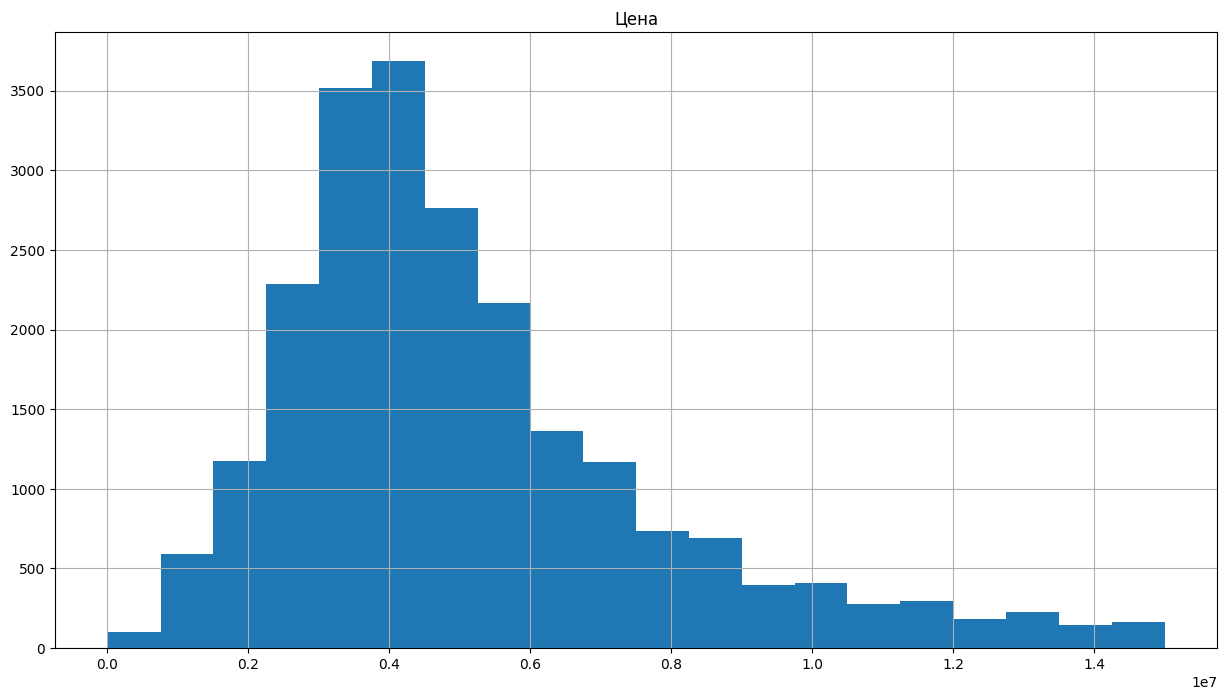

In [302]:
data.hist('last_price', figsize=HIST_SIZE, bins=20)
plt.title('Цена')
plt.show()

###### Выводы:
1. Распределение имеет форму, близкую к нормальной.
2. Наибольшее количество объектов имеет цену в диапазоне от 3 до 5 миллионов рублей.
3. Пик распределения приходится на цены около 4 миллионов рублей.
4. Большинство значений сосредоточено в диапазоне до 8 миллионов рублей.
5. Небольшое количество объектов имеет цену выше 10 миллионов рублей.

##### Колличество комнат

###### Гистограмма: Количество комнат в квартирах

<Axes: xlabel='rooms'>

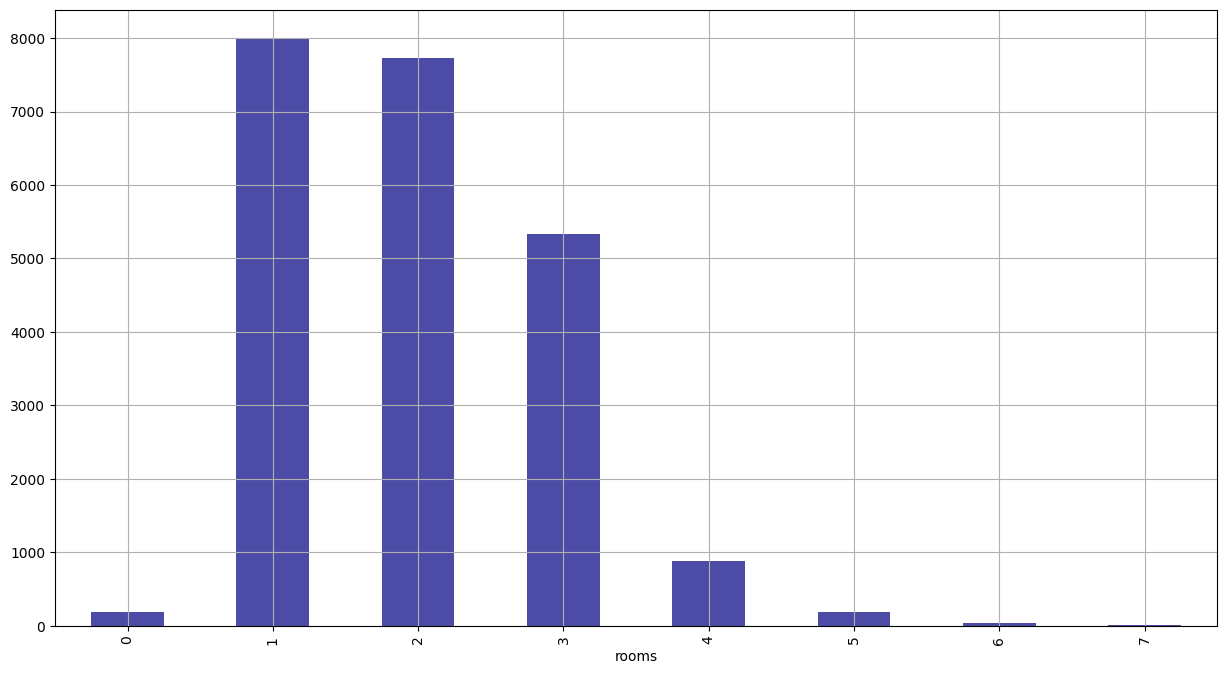

In [262]:
# ещё можно так
data.groupby('rooms')['rooms'].count().plot(kind='bar', grid=True, figsize=HIST_SIZE, color='#000080', alpha=0.7,)

###### Выводы:
1. Большинство квартир имеют 1, 2 или 3 комнаты.
2. Однокомнатные квартиры (1 комната) и двухкомнатные квартиры (2 комнаты) являются наиболее распространенными, с примерно равным количеством.
3. Трехкомнатные квартиры также встречаются часто, но в несколько меньшем количестве по сравнению с одно- и двухкомнатными квартирами.
4. Квартиры с 4 комнатами встречаются реже, но всё же составляют значительную долю.
5. Квартиры с 5 и более комнатами (5, 6, 7 комнат) встречаются очень редко.
6. Нулевое значение (0 комнат) вероятно указывает на студии, требуется дополнительный анализ.

##### Высота потолков

In [263]:
data['ceiling_height'].describe()

count    22359.000000
mean         2.710058
std          1.010951
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

<Axes: >

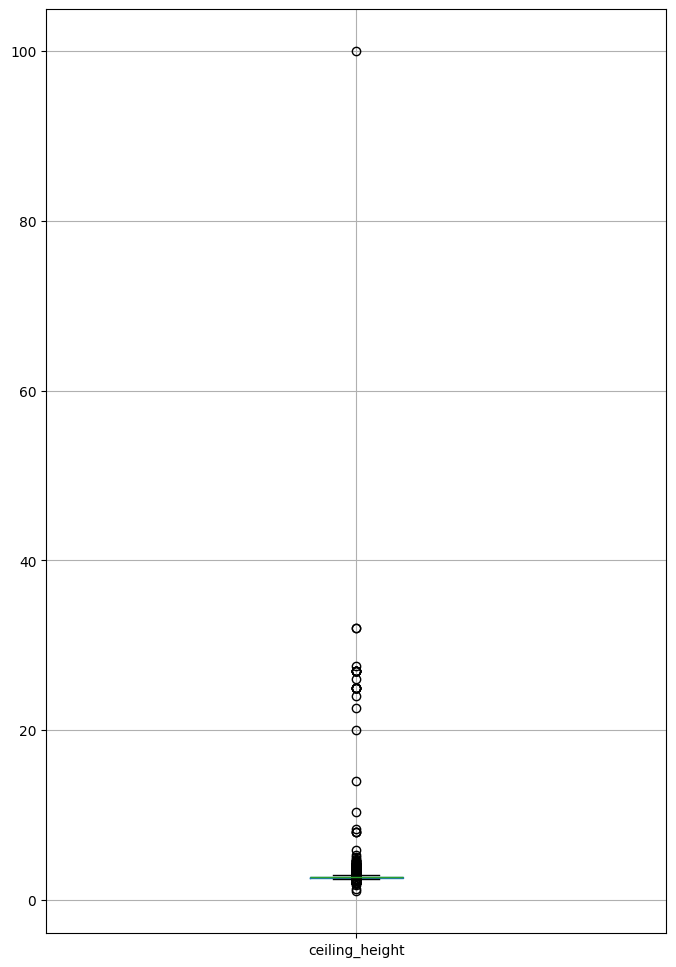

In [264]:
data.boxplot(column='ceiling_height', figsize=BOX_SIZE)

<Axes: >

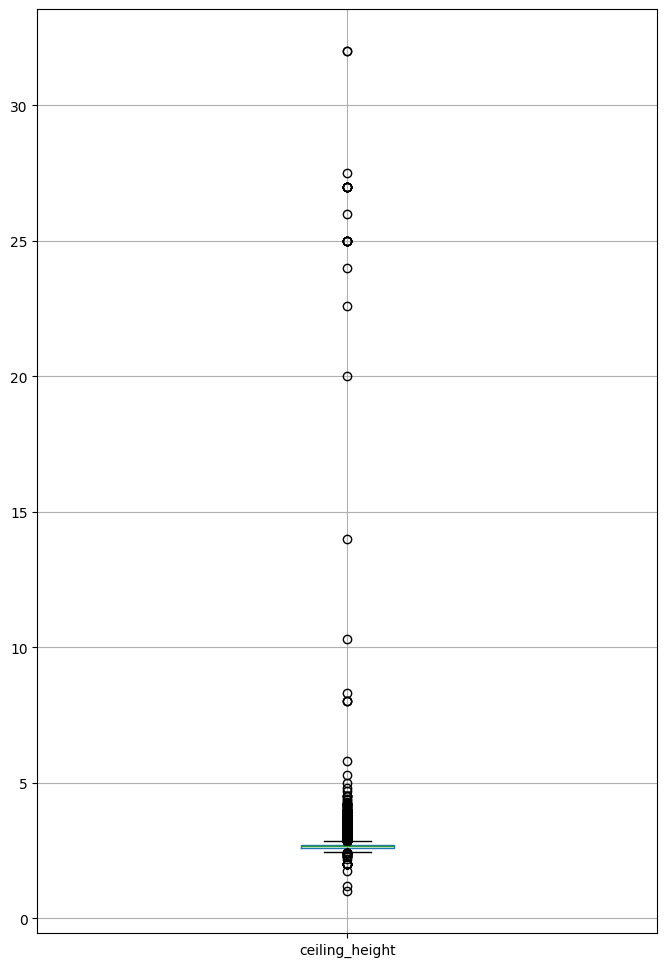

In [265]:
# больше 40 явно выброс
data.drop(index=data[data['ceiling_height'] > 40]['ceiling_height'].index, inplace=True)

data.boxplot(column='ceiling_height', figsize=BOX_SIZE)

In [266]:
data[data['ceiling_height'] > 5]['ceiling_height'].sort_values(ascending=True)

12628     5.3
21227     5.8
3474      8.0
17442     8.0
15743     8.0
5863      8.3
22309    10.3
15061    14.0
17496    20.0
20507    22.6
5076     24.0
18545    25.0
14382    25.0
355      25.0
9379     25.0
6246     25.0
4643     25.0
11285    25.0
5669     26.0
10773    27.0
5807     27.0
17857    27.0
5246     27.0
20478    27.0
4876     27.0
21824    27.0
22938    27.0
21377    27.5
22336    32.0
3148     32.0
Name: ceiling_height, dtype: float64

Можно выдвинуть гипотезу о том, что некоторые квартиры могут быть двухуровневыми или иметь необычно высокие потолки. Такие характеристики часто встречаются в апартаментах, которые располагаются на бывших производственных площадях.

Значения свыше 20 метров вероятно являются следствием технической ошибки, предлагаю что если значения больше или равные 20 разделить на 10, получим реальную высоту потолков.

In [267]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] <= 20, data['ceiling_height'] / 10)

<Axes: >

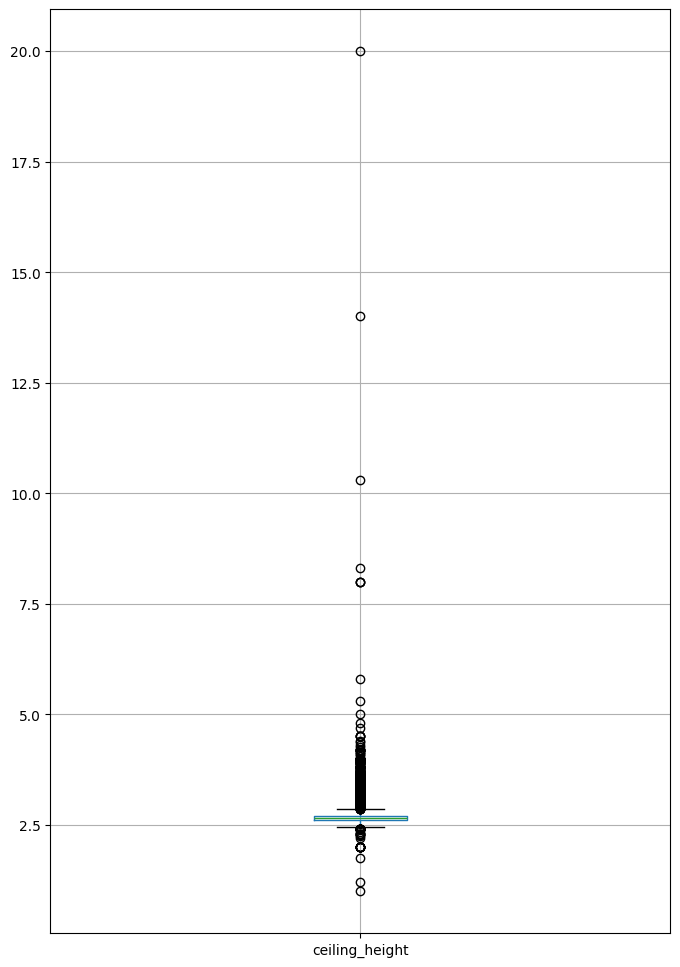

In [268]:
data.boxplot(column='ceiling_height', figsize=BOX_SIZE)

In [269]:
data.drop(index=data[data['ceiling_height'] > 5]['ceiling_height'].index, inplace=True)

###### Гистограмма: Высота потолков

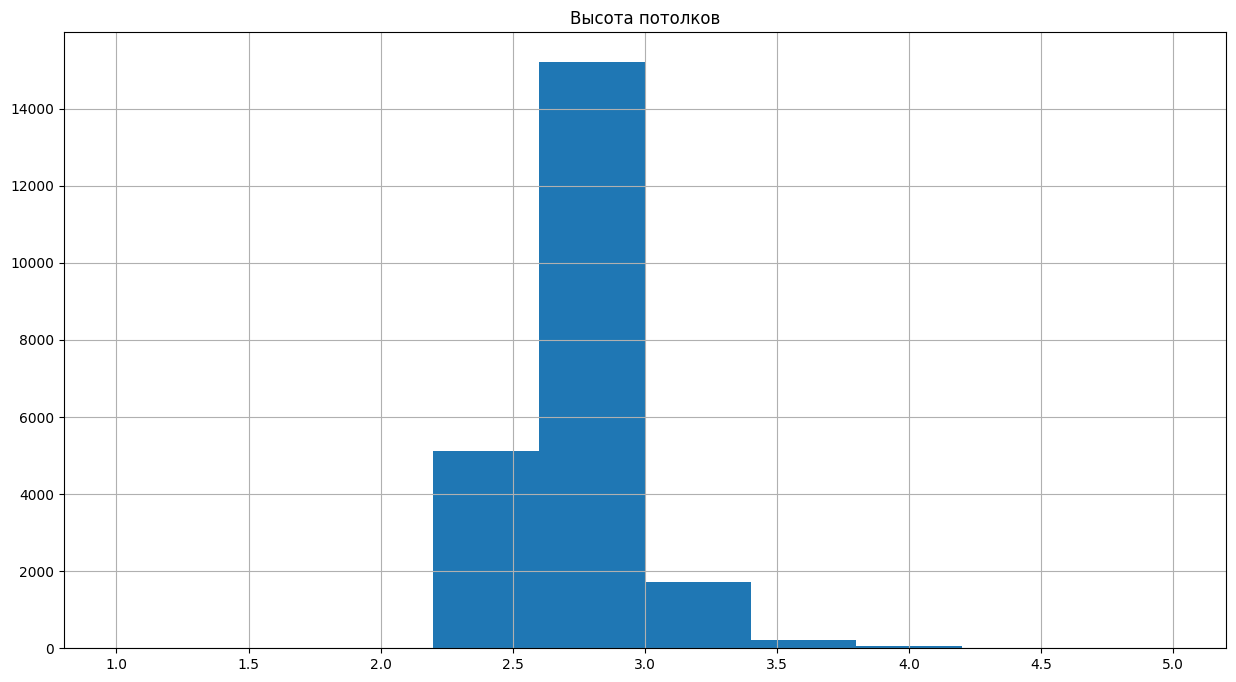

In [304]:
data.hist('ceiling_height', figsize=HIST_SIZE)
plt.title('Высота потолков')
plt.show()

###### Выводы:
1. Большинство квартир имеют высоту потолков около 2.5-3.0 метров.
2. Пик распределения приходится на высоту 2.5-2.7 метров, что является стандартной высотой для большинства жилых помещений.
3. Небольшое количество квартир имеет высоту потолков выше 3 метров, вплоть до 4 метров. Это может быть элитное жильё или апартаменты с высокими потолками

##### Тип этажа квартиры

###### Гистограмма: Распределение квартир по типу этажа 

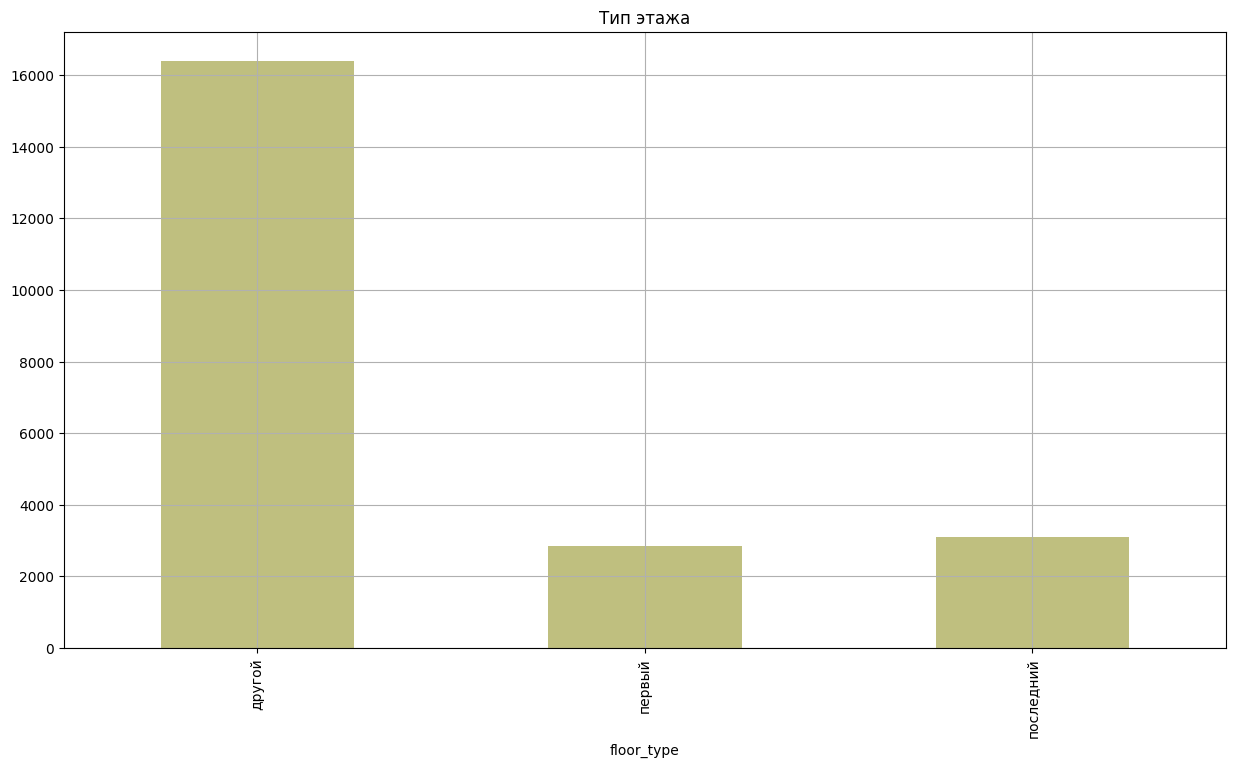

In [307]:
data.groupby('floor_type')['floor_type'].count().plot(kind='bar', grid=True, figsize=HIST_SIZE, color='#808000', alpha=0.5, title='Тип этажа')
plt.show()

###### Выводы:
1. На первых и последних этажах количество квартир примерно одинаково.
2. Большинство квартир расположено на "других" этажах
3. Распределение логично, так как большинство многоквартирных домов имеет большее количество средних этажей по сравнению с первым и последним.
4. Порядок столбцов влияет на визуальное восприятие, сортировка в данном случае происходит по первой букве названия типа этажа.

##### Общее количество этажей в доме

In [272]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'short_locality_name',
       'meter_price', 'day_of_the_week_exposition', 'month_exposition',
       'year_exposition', 'floor_type', 'cityCenters_nearest_round'],
      dtype='object')

<Axes: >

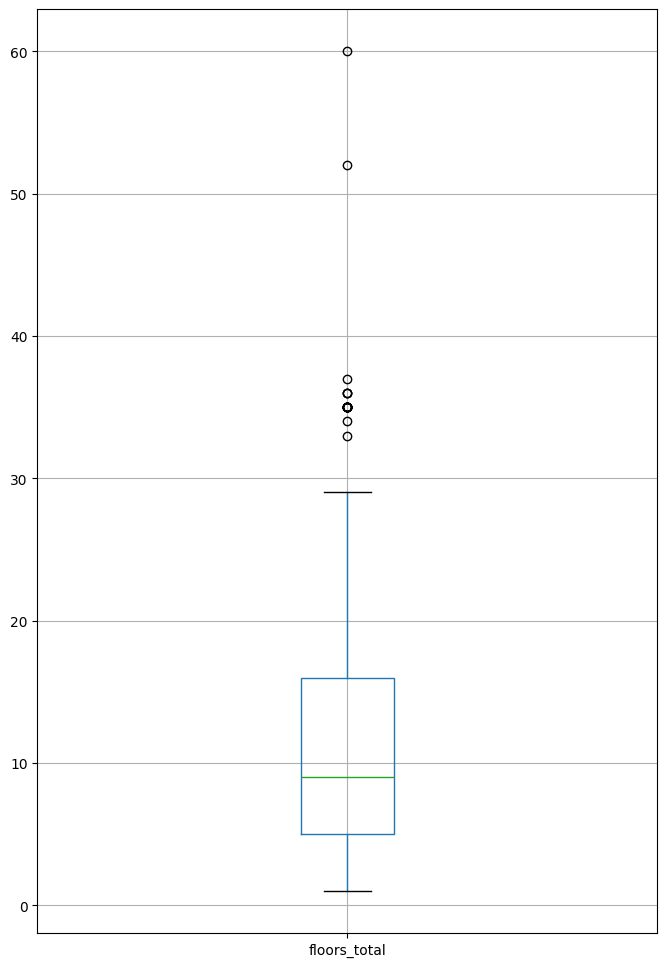

In [273]:
data.boxplot(column='floors_total', figsize=BOX_SIZE)

> Самым высоким в России, а также в Европе, является 462-метровый 87-этажный небоскрёб Лахта-центр в Санкт-Петербурге.

###### Гистограмма: Распределение количества этажей в домах

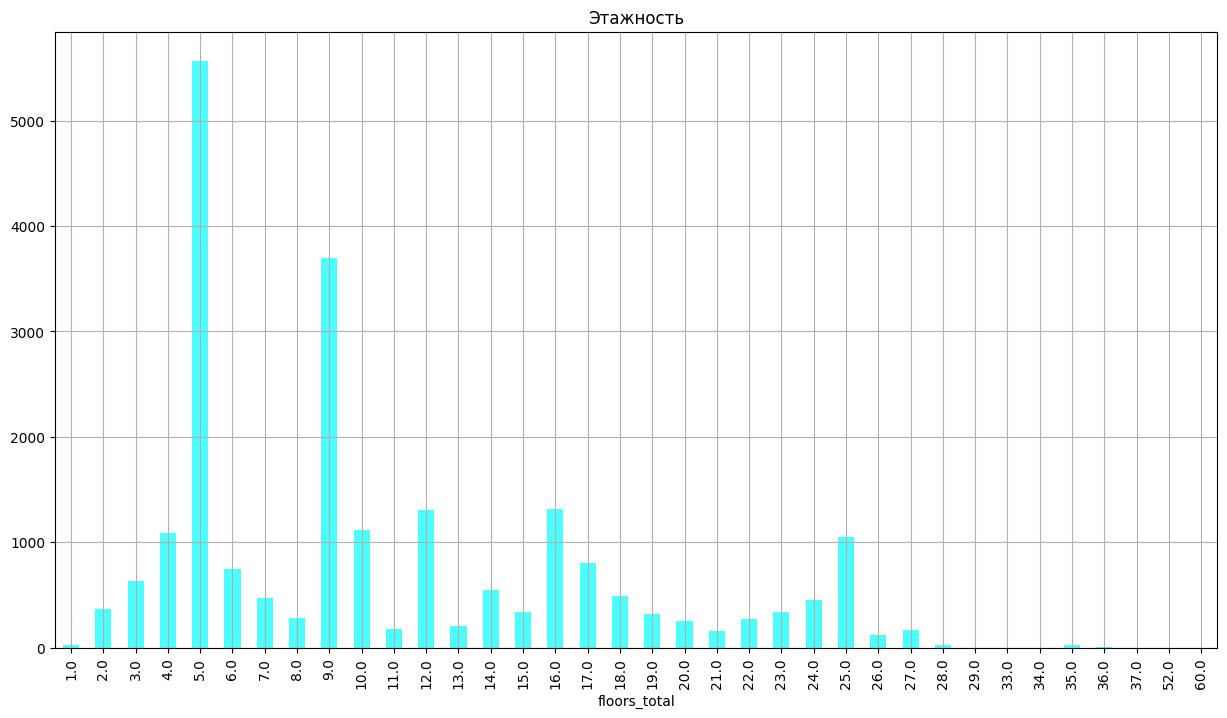

In [309]:
#  просто было интересно можно так или нет.
#  _describe = data['floors_total'].describe()
#  data.hist('floors_total', figsize=HIST_SIZE, range=(_describe['min'], _describe['max']), bins=int(_describe['max']))
data.groupby('floors_total')['floors_total'].count().plot(kind='bar', grid=True, figsize=HIST_SIZE, color='#00FFFF', alpha=0.7, title='Этажность')
plt.show()


###### Выводы:
* Наиболее часто встречающиеся значения количества этажей — 5 и 9 этажей.
* Значительные пики также наблюдаются для домов с 10, 12, 16 и 25 этажами.
* Дома выше 30 этажей можно рассматривать как небоскребы, которые встречаются реже.
* Выбросы на уровне 35 и 60 этажей, несмотря на их редкость, также включены в данные.
* Основная часть жилого фонда приходится на дома с 5 и 9 этажами, что подтверждает субъективное мнение о массовости таких домов.
* Значительное количество домов также имеет 10, 12, 16 и 25 этажей, что указывает на разнообразие в высотности жилых зданий.

##### Даты размещения (день недели, месяц, год)

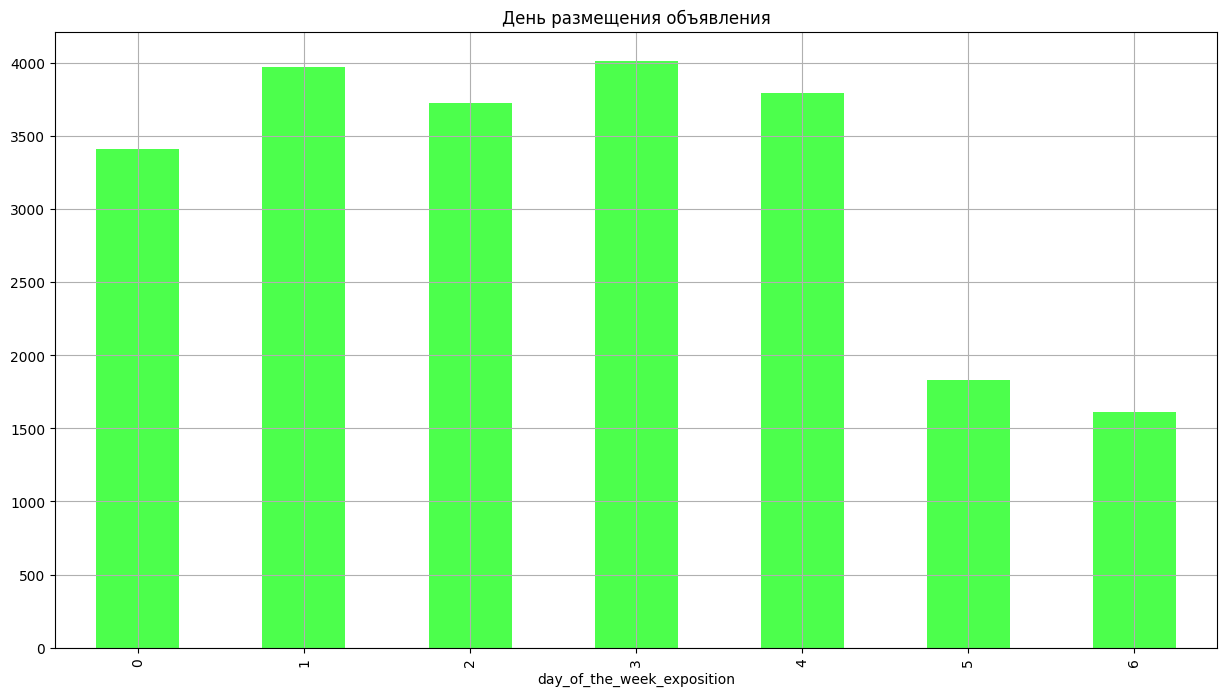

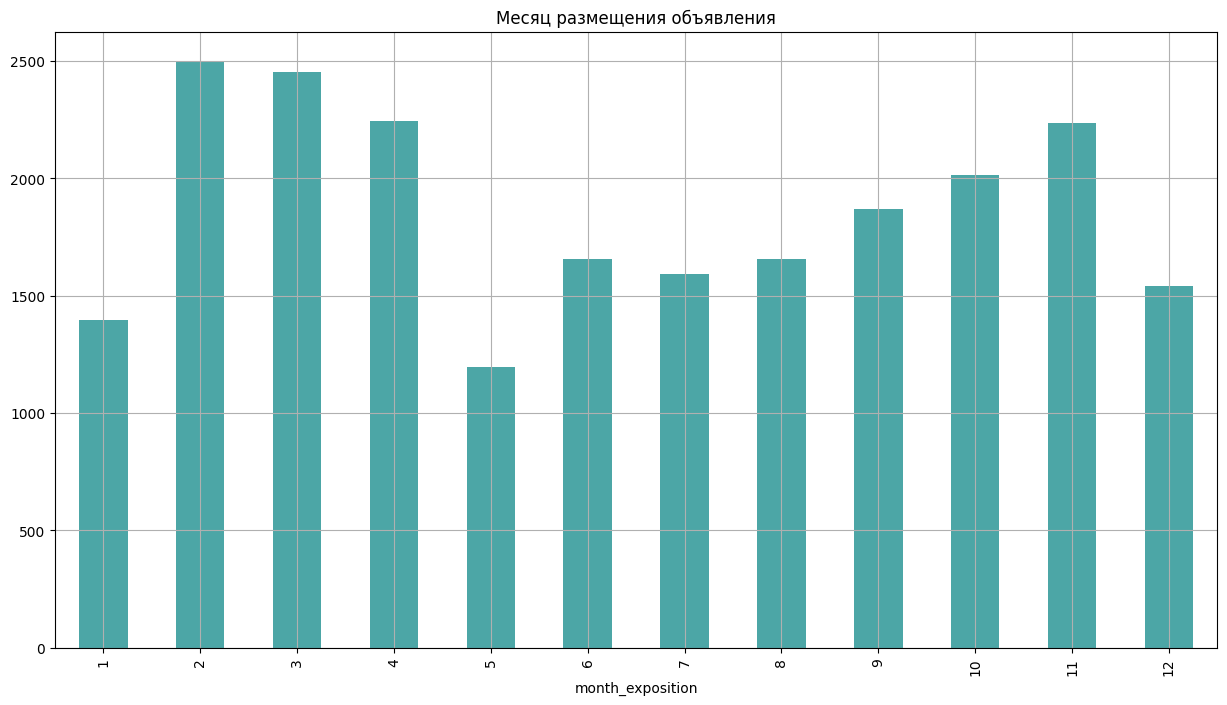

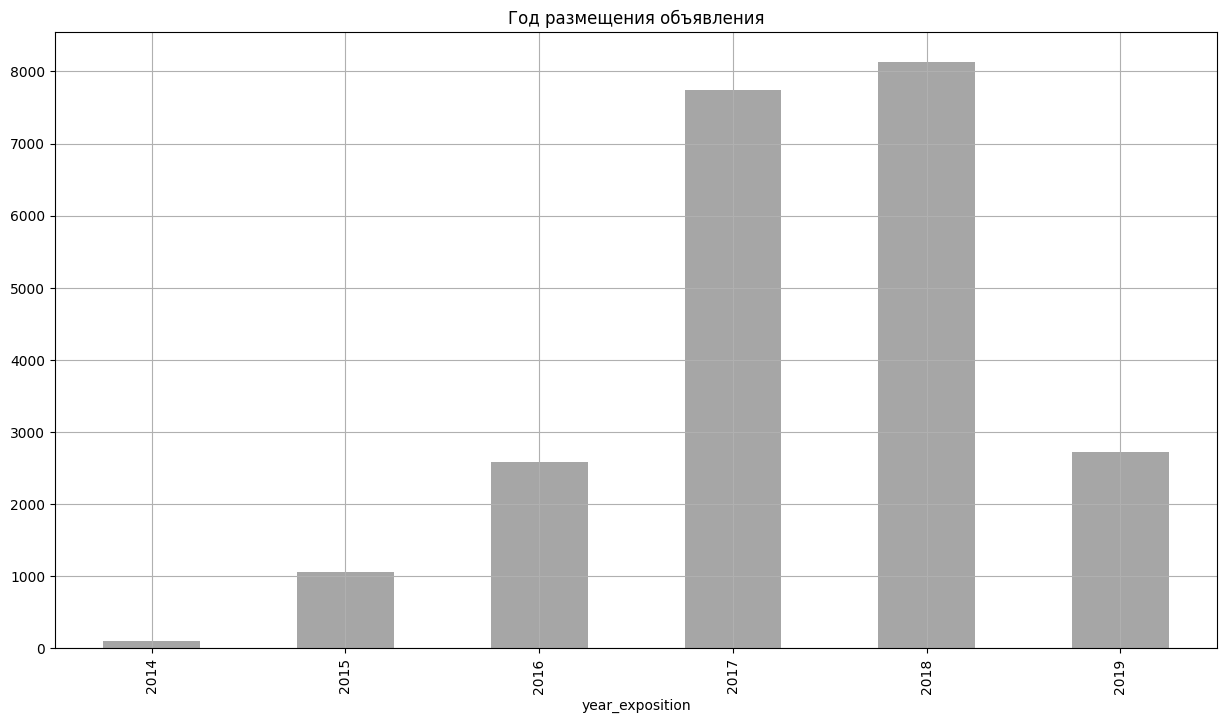

In [310]:
import matplotlib.pyplot as plt
date_list = ['day_of_the_week_exposition', 'month_exposition', 'year_exposition']
colors = ['#00FF00', '#008080', '#808080']
units = ['День', 'Месяц', 'Год']

for index, value in enumerate(date_list):
    #data.hist(value, color=colors[index], figsize=HIST_SIZE)
    data.groupby(value)[value].count().plot(kind='bar', grid=True, figsize=HIST_SIZE, color=colors[index], alpha=0.7, title=f'{units[index]} размещения объявления')
    plt.show()
    

In [276]:
data['first_day_exposition'].max()

Timestamp('2019-05-03 00:00:00')

###### Гистограмма 1. День недели, когда была опубликовано объявление
1. Максимальное количество объявлений приходится на понедельник (день 1) и четверг (день 3).
2. Значительное количество объявлений также опубликовано во вторник (день 2) и среду (день 4).
3. Минимальное количество объявлений опубликовано в субботу (день 6) и воскресенье (день 0).
4. Пятница (день 5) также показывает заметное снижение количества публикаций по сравнению с началом недели.
###### Гистограмма 2. Месяц, когда была опубликовано объявление
1. Наибольшее количество объявлений приходится на февраль (месяц 2) и март (месяц 3).
2. Высокая активность также наблюдается в январе (месяц 1) и апреле (месяц 4).
3. Меньшее количество объявлений наблюдается в мае (месяц 5) и июне (месяц 6).
4. Вторая половина года (с июля по декабрь) показывает более равномерное распределение, с пиками в октябре (месяц 10) и ноябре (месяц 11).
###### Гистограмма 3. Год, когда было опубликовано объявление
1. Данные за 2019 год представлены до мая, поэтому их нельзя использовать для полного анализа трендов. Показатели за 2019 год могут быть неполными и не отражают полный год.
2. Максимальное количество объявлений приходится на 2017 и 2018 годы.
3. Значительное количество объявлений также наблюдается в 2016 году.
4. Меньшее количество объявлений приходится на 2014 и 2015 годы, с минимальными значениями в 2014 году.
###### Возможные причины увеличения числа объявлений в 2017 и 2018 годах:
1. Наблюдается рост популярности платформы "Яндекс Недвижимость".
2. Растёт рынок недвижимости, что отражается в увеличении количества объявлений.
###### Выводы:
- Понедельник и четверг — наиболее популярные дни для публикации объявлений.
- Суббота и воскресенье — наименее популярные.
- Начало года (январь-март) — период высокой активности публикации объявлений.
- Май и июнь — период снижения активности.
- Вторая половина года — равномерное распределение с пиками в октябре и ноябре.
- Пик активности наблюдается в 2017 и 2018 годах.
- Данные за 2019 год представлены до мая и не могут использоваться для полного анализа трендов.

##### Расстояние до центра города в метрах

###### Гистограмма

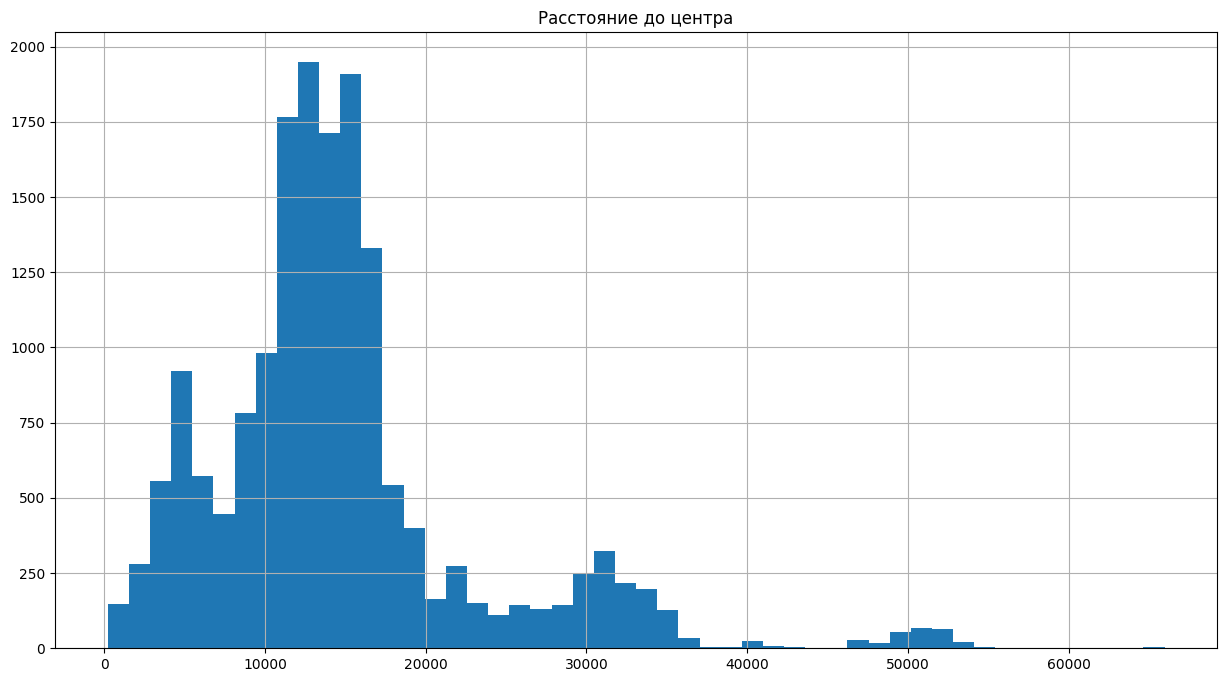

In [311]:
data.hist('cityCenters_nearest', figsize=HIST_SIZE, bins=50)
plt.title('Расстояние до центра')
plt.show()

###### Выводы:
1. Большинство объектов находится на расстоянии до 15,000 метров (15 км) от центра города.
2. Наиболее часто встречающееся расстояние до центра города колеблется в диапазоне от 10,000 до 12,000 метров (10-12 км).

##### Расстояние до ближайшего парка

###### Гистограмма

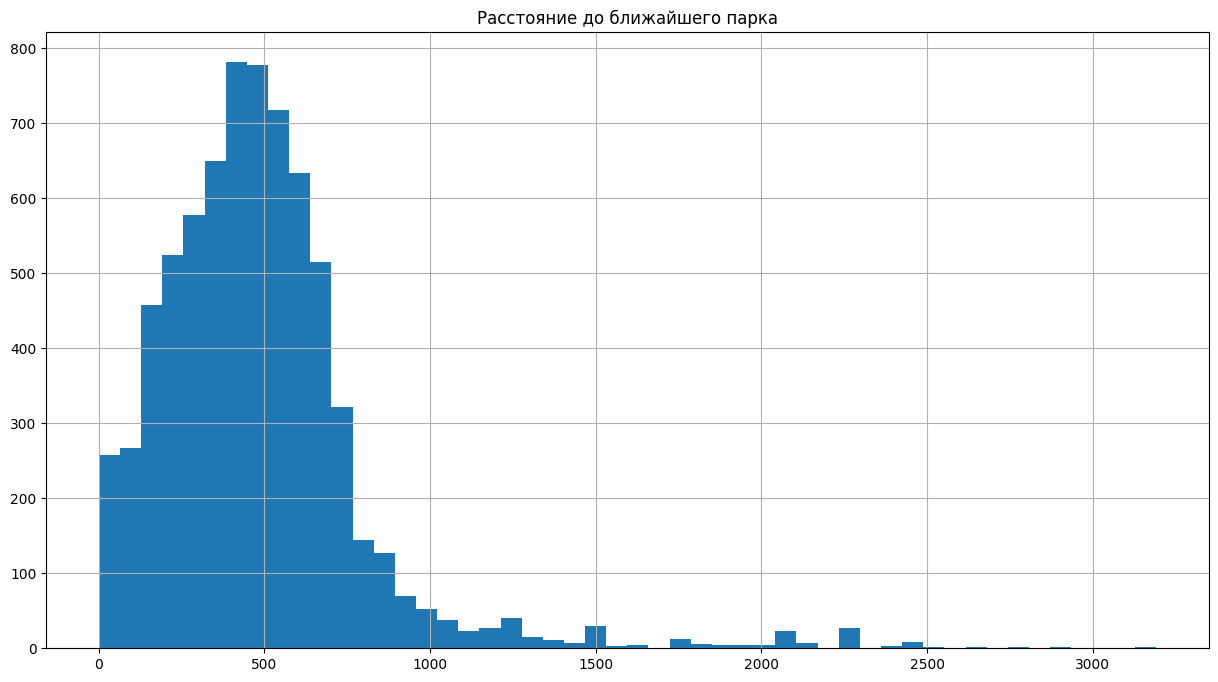

In [313]:
data.hist('parks_nearest', figsize=HIST_SIZE, bins=50)
plt.title('Расстояние до ближайшего парка')
plt.show()

###### Выводы:
1. Большинство объектов расположены на расстоянии до 1000 метров от ближайшего парка.
2. Наиболее часто встречающееся расстояние составляет около 500 метров.
3. Небольшое количество объектов расположено на расстоянии более 1500 метров от парка.
4. Важно учитывать, что в большой части датасета могут отсутствовать данные о расстоянии до парка, что может повлиять на полноту анализа.



### Как быстро продавались квартиры?

#### Гистограмма

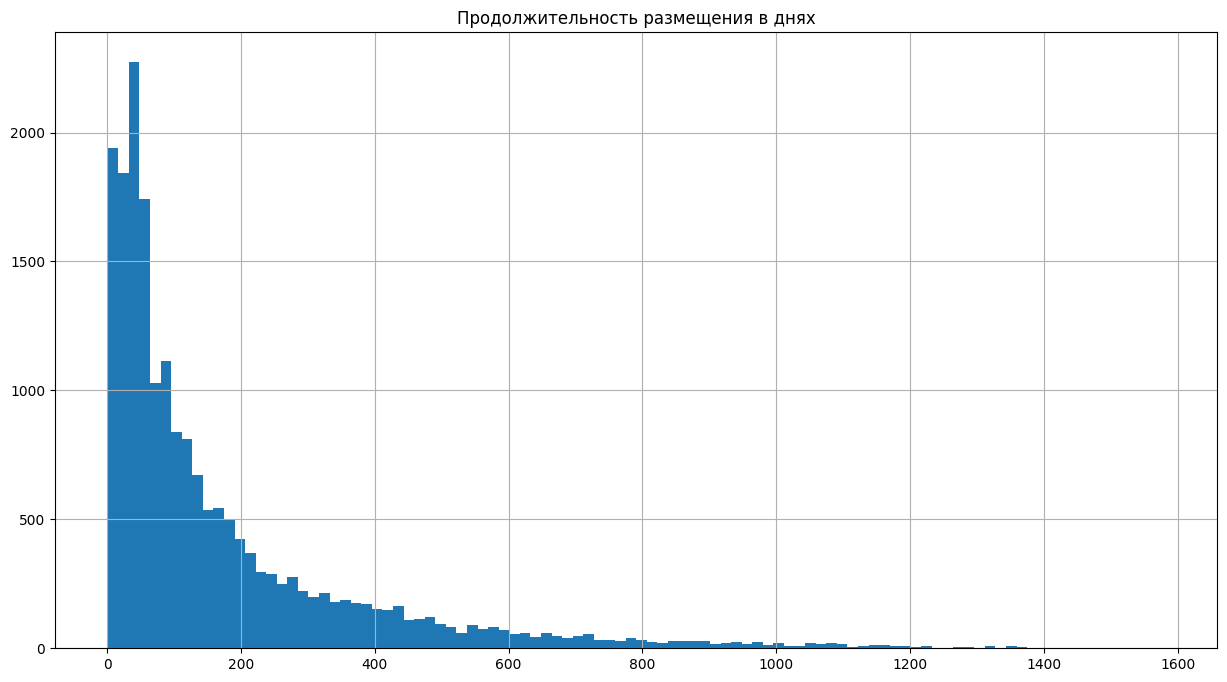

In [315]:
# увеличил кол-во 'корзин' с 50 до 100, что то появилось...

data.hist('days_exposition', figsize=HIST_SIZE, bins=100)
plt.title('Продолжительность размещения в днях')
plt.show()

Гистограмма показывает распределение времени продажи квартир (days_exposition).

In [316]:
data['days_exposition'].describe()

count    19535.000000
mean       176.117379
std        215.049380
min          1.000000
25%         44.000000
50%         93.000000
75%        223.500000
max       1580.000000
Name: days_exposition, dtype: float64

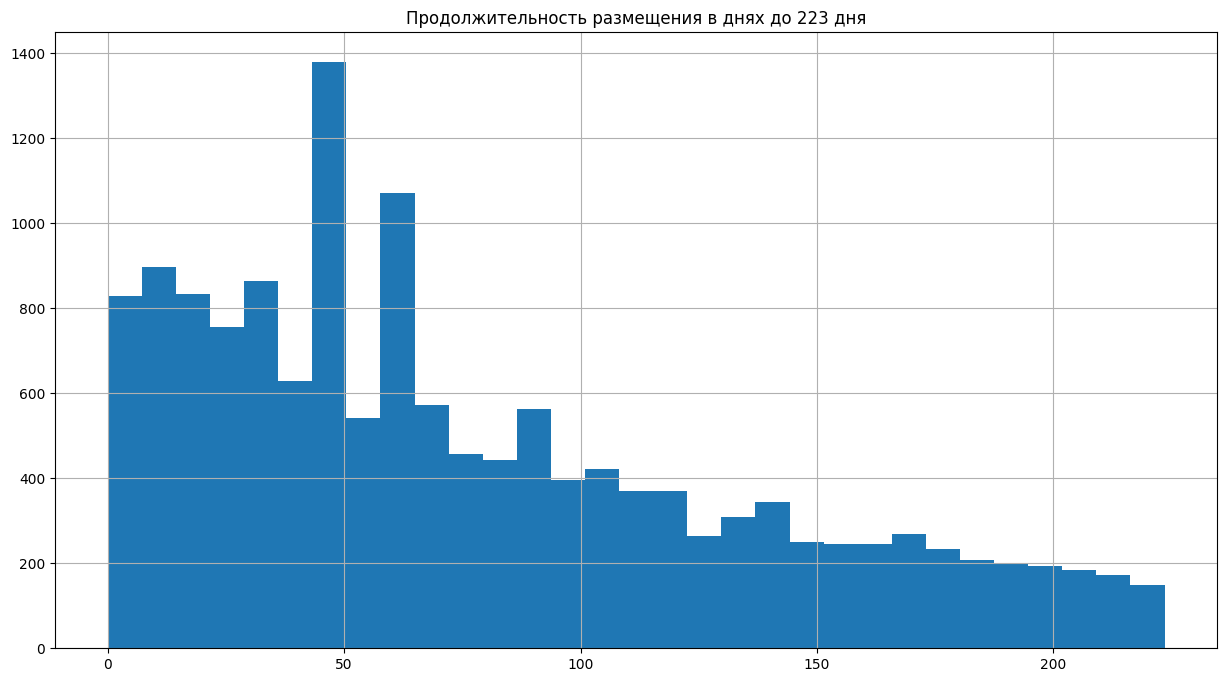

In [321]:
q3 = data['days_exposition'].describe()['75%']

bin = int(q3 / 7)

data.hist('days_exposition', figsize=HIST_SIZE, bins=bin, range=(0, q3))
plt.title(f'Продолжительность размещения в днях до {int(q3)} дня')
plt.show()

#### Пики:
Видно два явных пика на графике:
1. Первый пик приходится на период около 42-49 дней, с максимальным количеством объявлений около 1400.
2. Второй пик наблюдается на периоде около 56-63 дней, с количеством объявлений около 1000.

Значительные пики в районе 42-49 дней и 56-63 дней дней указывают на то, что эти временные интервалы являются характерными для рынка недвижимости.

Пики вероятно, могут быть связаны с интенсивными продажами на начальном этапе размещения объявлений.

#### Среднее и Медиана

In [280]:
print('Среднее время продажи:', data['days_exposition'].mean(), '\nМедианное время продажи:', data['days_exposition'].median())

Среднее время продажи: 176.11737906321986 
Медианное время продажи: 93.0


In [281]:
# числовое описание можно получить иначе, например
data['days_exposition'].describe()

count    19535.000000
mean       176.117379
std        215.049380
min          1.000000
25%         44.000000
50%         93.000000
75%        223.500000
max       1580.000000
Name: days_exposition, dtype: float64

In [282]:
# из него можно 'вытащить и среднее и медиану, min и max'
_describe = data['days_exposition'].describe()
print('Среднее:', _describe['mean'], 'Медиана', _describe['50%'], 'Min:', _describe['min'], 'Max:', _describe['max'])

Среднее: 176.11737906321986 Медиана 93.0 Min: 1.0 Max: 1580.0


#### Выводы
* Типичное время продажи:
    - Медианное время продажи (93 дня) указывает на то, что половина всех квартир продавалась быстрее этого срока, а другая половина — медленнее.
    - Среднее время продажи (195.1 дня) выше медианного, что свидетельствует о наличии некоторых квартир, которые продавались значительно дольше и влияют на среднее значение.  

* Быстрая продажа:
    - Продажи, которые происходили в пределах 44 дней (первый квартиль), можно считать быстрыми.
    - Пики которые мы видим на гистограмме, указывают на то что значительная часть недвижимости продаётся достаточно быстро.

* Продолжительная продажа:
    - Продажи, длившиеся более 223 дней (третий квартиль), можно считать относительно долгими.

### Факторы, которые больше всего влияют на общую (полную) стоимость объекта.

In [283]:
# просто так удобнее
data.insert(0, 'id', data.index + 1)

In [284]:
stat = data.pivot_table(index='id', values=['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor'], aggfunc='median')
stat.corr()

,floor,kitchen_area,last_price,living_area,rooms,total_area
floor,1.000000,0.195902,0.106279,-0.132180,-0.172228,-0.037778
kitchen_area,0.195902,1.000000,0.537196,0.226776,0.113732,0.485618
last_price,0.106279,0.537196,1.000000,0.635281,0.490784,0.746835
living_area,-0.132180,0.226776,0.635281,1.000000,0.885900,0.919815
rooms,-0.172228,0.113732,0.490784,0.885900,1.000000,0.803582
total_area,-0.037778,0.485618,0.746835,0.919815,0.803582,1.000000


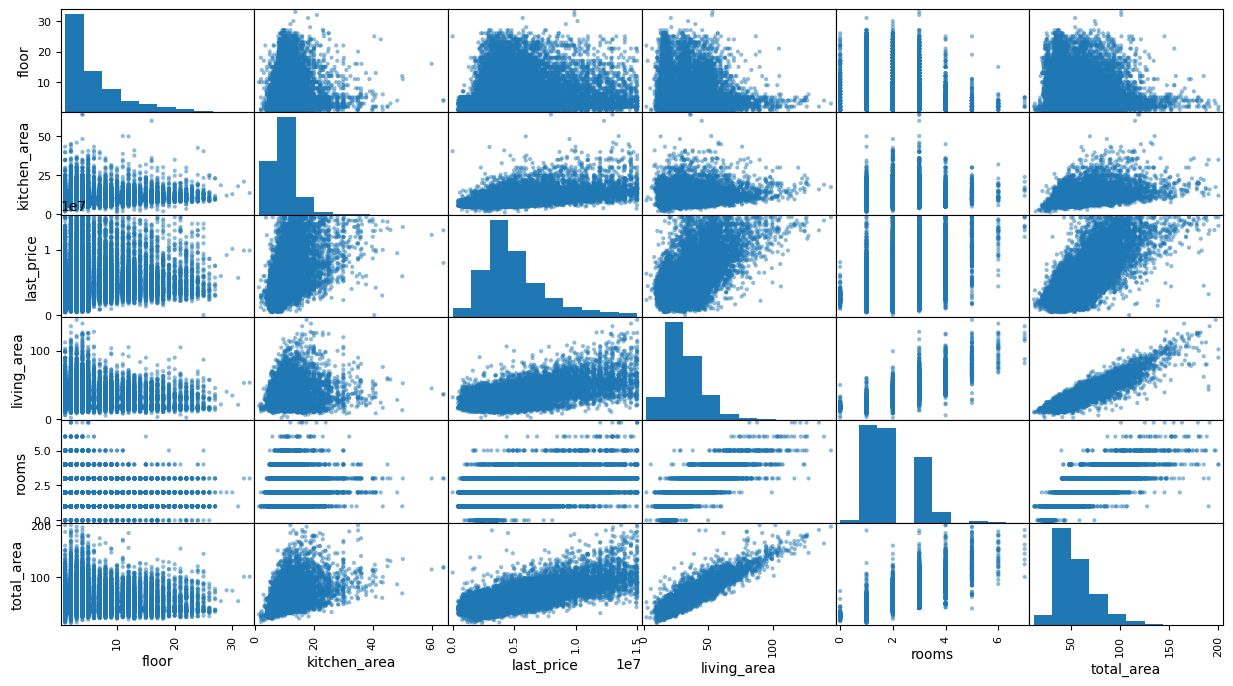

In [326]:
pd.plotting.scatter_matrix(stat, figsize=HIST_SIZE)
plt.show()

#### Основные факторы, влияющие на общую стоимость объекта
1. Площадь недвижимости (total_area):

Из диаграммы видно, что существует четкая положительная корреляция между общей площадью и стоимостью недвижимости. Чем больше общая площадь, тем выше стоимость.
Жилая площадь (living_area):

Также наблюдается положительная корреляция между жилой площадью и стоимостью. Большее количество квадратных метров жилой площади связано с увеличением стоимости.

2. Площадь кухни (kitchen_area):

Имеется положительная, но менее выраженная корреляция между площадью кухни и стоимостью недвижимости.

3. Количество комнат (rooms):

Наблюдается положительная корреляция между количеством комнат и стоимостью недвижимости. Однако, данные распределены довольно плотно по дискретным значениям количества комнат (1, 2, 3, и т.д.), что может немного ограничивать точность оценки этой зависимости.

4. Этаж (floor):

Корреляция между этажом и стоимостью менее выражена, но есть небольшая положительная зависимость, особенно на нижних этажах.

#### Выводы:

На основании анализа матрицы диаграмм рассеяния, можно сделать вывод, что наиболее значимыми факторами, влияющими на общую стоимость объекта недвижимости, являются:

- Общая площадь (total_area)
- Жилая площадь (living_area)
- Количество комнат (rooms)
- Площадь кухни (kitchen_area)

Этаж (floor) оказывает некоторое влияние, но оно менее значимо по сравнению с другими параметрами.

#### Медианная стоимость квартир в зависимости от типа этажа

In [286]:
data.pivot_table(columns=['floor_type'], values=['last_price'], aggfunc=['median'])

median                      
floor_type     другой     первый  последний
last_price  4690000.0  3850000.0  4150000.0

#### Выводы:
* Квартиры на других этажах (не первый и не последний) имеют самую высокую медианную стоимость, что указывает на их большую популярность и удобство.
* Квартиры на первом этаже стоят дешевле всех из-за ряда неудобств, связанных с их расположением.
* Квартиры на последнем этаже имеют промежуточную стоимость, учитывая как преимущества, так и недостатки их расположения.

#### Данные о медианной стоимости недвижимости по годам с 2014 по 2019 годы

In [287]:
data.pivot_table(columns=['year_exposition'], values=['last_price'], aggfunc=['median'])

median                                              \
year_exposition       2014       2015       2016       2017       2018   
last_price       6051250.0  5000000.0  4380000.0  4350000.0  4499000.0   

                            
year_exposition       2019  
last_price       4940000.0

#### Выводы:
* В 2014 году медианная цена недвижимости была самой высокой (6,051,250).
С 2014 по 2017 годы наблюдается значительное снижение медианных цен, достигающее минимума в 2017 году (4,350,000).
Начиная с 2018 года, цены начали восстанавливаться, что отражает общий устойчивый рост в последующие годы, достигнув 4,940,000 в 2019 году.

* Снижение цен с 2014 по 2017 годы может быть связано с экономическими или рыночными факторами, такими как снижение спроса или изменения в экономике.
Рост цен с 2017 года указывает на восстановление рынка и, возможно, улучшение экономической ситуации.

* Данные за 2014-2016 годы:
Субъективное мнение, результаты недостаточно объективны из-за малого количества данных.
Необходимо провести более глубокий анализ данных за 2014-2016 годы, чтобы определить причины нестабильности и малого количества данных.
Вероятно выводы изменяться.



### Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [325]:
# в задании сказано 'mean', я бы использовал 'median'
locality_stat = data.pivot_table(
                                index=['locality_name'],
                                values=['id', 'last_price','total_area'], 
                                aggfunc={'id': len, 'last_price': 'mean', 'total_area': 'mean'}
                                ).sort_values('id', ascending=False)[:11]
locality_stat['mean_meter_price'] = locality_stat['last_price'] / locality_stat['total_area']
locality_stat.sort_values('mean_meter_price', ascending=False)

,id,last_price,total_area,mean_meter_price
locality_name,,,,
Санкт-Петербург,14478,6.088013e+06,57.365040,106127.577191
Пушкин,351,5.634507e+06,55.685983,101183.578450
Кудрово,470,4.354895e+06,46.391340,93873.020139
поселок Парголово,326,4.477609e+06,51.061350,87690.764087
Петергоф,199,4.247196e+06,50.559548,84003.836463
Мурино,586,3.680841e+06,44.144010,83382.564589
поселок Шушары,439,4.109809e+06,53.886925,76267.270155
Колпино,337,3.866289e+06,52.358279,73842.926901
Гатчина,307,3.488337e+06,50.942932,68475.381534


### Квартиры в Санкт-Петербурге, их средняя стоимость на разном удалении от центра

#### Населенные пункты с самой высокой стоимостью квадратного метра:
1. Санкт-Петербург - 106127.577191
2. Пушкин - 101183.578450
3. Кудрово - 93873.020139
#### Населенные пункты с самой низкой стоимостью квадратного метра:
1. Гатчина - 68475.381534
2. Всеволожск - 66654.180094
3. Выборг - 57195.409692
#### Вывод:
Таким образом, наиболее дорогим по стоимости квадратного метра является Санкт-Петербург, а наименее дорогим - Выборг.


In [289]:
nerest_stat = data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_round', values=['last_price','total_area'])
nerest_stat['mean_price'] = nerest_stat['last_price'] / nerest_stat['total_area']

#### Граффик средней стоимости квартивы в зависимости от удаления от центра

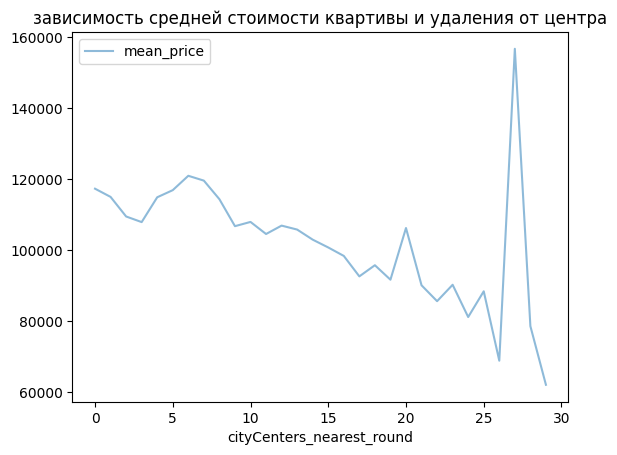

In [330]:
nerest_stat.plot(use_index=True, y='mean_price', alpha=0.5, title='зависимость средней стоимости квартивы и удаления от центра')
plt.show()


#### Выводы
График иллюстрирует типичную тенденцию на рынке недвижимости, где близость к центру города коррелирует с более высокими ценами на недвижимость, хотя и с местными вариациями и аномалиями. Резкий скачок требует дальнейшего исследования для понимания уникальных факторов, способствующих этой аномалии.
* Ближе к центру города (0-10 км):
Недвижимость относительно дороже с незначительными колебаниями. Высокие начальные цены отражают премиальную стоимость центральных районов.
* Среднее расстояние (10-20 км):
Цены постепенно снижаются, что указывает на переходную зону, где влияние удобств центрального расположения уменьшается, но все еще имеет значение.
* Дальше от центра города (20-30 км):
Цены становятся более переменными и в целом ниже, за исключением резкого скачка около 25 единиц. Эта зона может иметь особые характеристики, влияющие на повышение цен.

### Общий вывод

<div style="border:solid Chocolate 2px; padding: 40px">

#### Предобработка данных:
1. **Человеческий фактор и технические ошибки**: Пропуски в данных могут возникать как по причине человеческого фактора (например, ceiling_height, floors_total, living_area, kitchen_area, balcony, locality_name), так и из-за технических ошибок (например, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, is_apartment, days_exposition).
2.  **Обработка пропусков**: Для заполнения пропусков в данных были предложены логичные замены, например, использование медианных значений для высоты потолков, предположение отсутствия балкона при пропусках в этом столбце и т.д.
Пропуски в автоматически заполняемых столбцах лучше не заполнять предположительными значениями, а обратиться к разработчикам для выяснения причин.
3. **Преобразование данных**: Было проведено преобразование данных, включая преобразование типов данных, округление площадей и преобразование значений в целочисленные для столбцов, заполняемых автоматически.

#### Ответы на цели проекта:
1. **Анализ распределения площадей и цен**: 
Распределение площадей объектов недвижимости показало, что большинство объектов имеют площадь от 30 до 50 квадратных метров.
Распределение жилой площади объектов недвижимости подтвердило, что большинство объектов имеют жилую площадь от 15 до 40 квадратных метров.
Анализ цен объектов недвижимости показал, что основная масса объектов находится в диапазоне от 3 до 5 миллионов рублей.

2. **Идентификация факторов, влияющих на стоимость недвижимости**: Было выявлено, что на стоимость недвижимости влияют различные факторы, такие как общая площадь, жилая площадь, площадь кухни, наличие балкона и другие параметры.

#### Рекомендации:
1. **Улучшение качества данных**:
    - Рекомендуется улучшить процессы ввода данных пользователями, чтобы минимизировать пропуски и ошибки.
    - Для величин регламентированных, СНИП, СанПин и другими регламентами, например **высота потолков** рекомендуется применять фильтрацию ввода.
    - Обратиться к разработчикам геосервисов для устранения технических ошибок в автоматически заполняемых данных.

2. **Редкие и нестандартные данные**: Стоит обратить особое внимание на редкие и нестандартные данные, аномалии могут быть признаком мошеннической деятельности.

3. **Проведенный анализ показал**, что большая часть объектов имеет небольшую площадь и умеренные цены, что может быть полезно для стратегического планирования и маркетинга.
